<a href="https://colab.research.google.com/github/Praveen76/Loan-Approval-Classifier-Model-using-Non-Linear-Models/blob/main/End_to_end_Loan_Approval_Classifier_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Import libraries and data

In [276]:
!git clone https://github.com/Praveen76/Loan-Approval-Classifier-Model-using-Non-Linear-Models.git
%cd Loan-Approval-Classifier-Model-using-Non-Linear-Models

Cloning into 'Loan-Approval-Classifier-Model-using-Non-Linear-Models'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 129 (delta 78), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (129/129), 20.45 MiB | 6.94 MiB/s, done.
Resolving deltas: 100% (78/78), done.
/content/Loan-Approval-Classifier-Model-using-Non-Linear-Models/Loan-Approval-Classifier-Model-using-Non-Linear-Models/Loan-Approval-Classifier-Model-using-Non-Linear-Models/Loan-Approval-Classifier-Model-using-Non-Linear-Models/Loan-Approval-Classifier-Model-using-Non-Linear-Models/Loan-Approval-Classifier-Model-using-Non-Linear-Models/Loan-Approval-Classifier-Model-using-Non-Linear-Models


In [277]:
!pip install shap xgboost plotly scikit-plot seaborn statsmodels tabulate matplotlib imblearn nbformat>=4.2.0


In [278]:

import sys

# Print Python version
print("Python version")
print(sys.version)
print("")

# Print installed package versions
print("Installed package versions")
for module in sys.modules:
    try:
        version = sys.modules[module].__version__
        print(f"{module}: {version}")
    except AttributeError:
        pass


Python version
3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]

Installed package versions
re: 2.2.1
ipaddress: 1.0
zlib: 1.0
ipykernel._version: 6.17.1
json: 2.0.9
jupyter_client._version: 6.1.12
platform: 1.0.8
zmq.sugar.version: 26.2.1
zmq.sugar: 26.2.1
zmq: 26.2.1
traitlets._version: 5.7.1
traitlets: 5.7.1
logging: 0.5.1.2
socketserver: 0.4
argparse: 1.1
jupyter_core.version: 5.8.1
jupyter_core: 5.8.1
platformdirs.version: 4.3.8
platformdirs: 4.3.8
jupyter_client: 6.1.12
ipykernel: 6.17.1
IPython.core.release: 7.34.0
pygments: 2.19.2
ptyprocess: 0.7.0
pexpect: 4.9.0
_csv: 1.0
csv: 1.0
decorator: 4.4.2
pickleshare: 0.7.5
backcall: 0.2.0
wcwidth: 0.2.13
prompt_toolkit: 3.0.51
urllib.request: 3.11
IPython: 7.34.0
_curses: b'2.2'
dateutil._version: 2.9.0.post0
dateutil: 2.9.0.post0
six: 1.17.0
_decimal: 1.70
decimal: 1.70
psutil: 5.9.5
debugpy.public_api: 1.8.15
debugpy: 1.8.15
xmlrpc.client: 3.11
http.server: 0.6
_ctypes: 1.1.0
ctypes: 1.1.0
_pydevd_frame_eval.vendored.bytecode: 0.

# Step 0: Import libraries & load Data

In [279]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from tabulate import tabulate

import warnings

warnings.filterwarnings("ignore")

In [280]:
loan_original=pd.read_csv('./data.csv',parse_dates=['DateAdded','ApprovalDate'])
loan_original=loan_original.infer_objects()

loan_original.head()

,LeadID,DateAdded,LeadSourceGroup,LoanOfficer,Group,ZipCode,LoanNumber,ApprovalDate,BranchCode,LoanPurpose,...,BorrowerAge,BorrowerYearsInSchool,BorrowerTotalMonthlyIncome,BorrowerOwnRent,BorrowerCity,BorrowerState,IsCoBorrowerower,CoBorrowerYearsInSchool,CoBorrowerAge,CoBorrowerTotalMonthlyIncome
0,13067,2013-05-01 18:54:00,NaN,"Narmour, Derrick",Refinance Team - 4103,75078.0,41032026021,NaT,4103.0,Refinance ...,...,36,18,6083.00,NaN,Prosper,TX,True,0,0,0.0
1,14396,2013-05-07 16:53:00,TV,"Johnson, Adrienne",Refinance Team - 4103,76064.0,4103198104,2019-07-21,4103.0,Refinance Cash-out ...,...,52,16,8883.71,Own,Maypearl,TX,True,12,55,0.0
2,14855,2013-05-09 12:53:00,NaN,"Frank, Michael",Refinance Team - 4103,76017.0,4102192789,2019-03-26,4102.0,Refinance Cash-out ...,...,60,12,17538.30,Own,Arlington,TX,True,0,0,0.0
3,26269,2013-07-01 17:25:00,TV,"Benitez, Bryan",Refinance Team - 4102,75238.0,4102193097,2019-04-05,4102.0,Refinance Cash-out ...,...,54,16,13299.09,Own,Dallas,TX,True,0,0,0.0
4,37010,2013-08-30 09:58:00,TV,"Nguyen, Tu",Refinance Team - 4102,77450.0,4102190764,2019-02-01,4102.0,Refinance Cash-out ...,...,49,16,6254.91,Own,Katy,TX,True,0,0,0.0


In [281]:
loan_original.columns

Index(['LeadID', 'DateAdded', 'LeadSourceGroup', 'LoanOfficer', 'Group',
       'ZipCode', 'LoanNumber', 'ApprovalDate', 'BranchCode', 'LoanPurpose',
       'LoanType', 'TotalLoanAmount', 'CreditScore', 'CLTV', 'DTI',
       'BorrowerAge', 'BorrowerYearsInSchool', 'BorrowerTotalMonthlyIncome',
       'BorrowerOwnRent', 'BorrowerCity', 'BorrowerState', 'IsCoBorrowerower',
       'CoBorrowerYearsInSchool', 'CoBorrowerAge',
       'CoBorrowerTotalMonthlyIncome'],
      dtype='object')

In [282]:
loan_original.LoanPurpose.value_counts()

,count
LoanPurpose,
Refinance Cash-out,6479
Refinance,5236
Purchase,1489
VA IRRRL,212
FHA Streamlined Refinance,35


In [283]:
loan_original.LoanType.value_counts()

,count
LoanType,
Conventional,12440
FHA,682
VA,317
USDA Rural,12


# Step 1: Data Sanity checks

In [284]:
loan_original.describe(include = "all")


,LeadID,DateAdded,LeadSourceGroup,LoanOfficer,Group,ZipCode,LoanNumber,ApprovalDate,BranchCode,LoanPurpose,...,BorrowerAge,BorrowerYearsInSchool,BorrowerTotalMonthlyIncome,BorrowerOwnRent,BorrowerCity,BorrowerState,IsCoBorrowerower,CoBorrowerYearsInSchool,CoBorrowerAge,CoBorrowerTotalMonthlyIncome
count,13451.000000,13451,13439,13447,13447,1.310400e+04,1.345100e+04,9582,13449.000000,13451,...,13451.000000,13451.000000,13451.000000,13372,13449,13449,13451,13451.000000,13451.000000,13451.000000
unique,NaN,NaN,10,47,8,NaN,NaN,NaN,NaN,5,...,NaN,NaN,NaN,3,778,27,1,NaN,NaN,NaN
top,NaN,NaN,Internet,"Vander Plaats, Brian",Refinance Team - 4102,NaN,NaN,NaN,NaN,Refinance Cash-out ...,...,NaN,NaN,NaN,Own,Dallas,TX,True,NaN,NaN,NaN
freq,NaN,NaN,6739,911,3787,NaN,NaN,NaN,NaN,6479,...,NaN,NaN,NaN,12354,861,13356,13451,NaN,NaN,NaN
mean,507695.303472,2020-02-11 17:54:46.662701824,NaN,NaN,NaN,1.033255e+07,2.686898e+10,2020-03-31 23:20:10.519724288,4102.771433,NaN,...,50.221024,15.306371,8613.028929,NaN,NaN,NaN,NaN,7.111813,23.695116,1921.708188
min,581.000000,2013-01-15 09:51:00,NaN,NaN,NaN,2.155000e+03,4.101200e+09,2018-11-16 00:00:00,4101.000000,NaN,...,0.000000,-20.000000,-7647.250000,NaN,NaN,NaN,NaN,0.000000,0.000000,-2575.330000
25%,461287.500000,2019-09-25 01:54:00,NaN,NaN,NaN,7.509300e+04,4.103202e+09,2019-10-16 00:00:00,4102.000000,NaN,...,41.000000,14.000000,4865.685000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,519016.000000,2020-04-30 10:08:00,NaN,NaN,NaN,7.603400e+04,4.101202e+10,2020-05-19 00:00:00,4102.000000,NaN,...,50.000000,16.000000,7208.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
75%,575237.500000,2020-08-25 12:33:00,NaN,NaN,NaN,7.702300e+04,4.103192e+10,2020-09-23 00:00:00,4103.000000,NaN,...,58.000000,16.000000,10669.250000,NaN,NaN,NaN,NaN,16.000000,48.000000,3220.655000
max,607345.000000,2020-12-26 09:14:00,NaN,NaN,NaN,4.102197e+09,4.112203e+10,2020-12-26 00:00:00,4112.000000,NaN,...,92.000000,52.000000,901250.000000,NaN,NaN,NaN,NaN,106.000000,92.000000,65239.250000


In [285]:
#Check for duplicate values
loan_original[loan_original['LeadID'].duplicated(keep = False) == True].sort_values(['LeadID'])

,LeadID,DateAdded,LeadSourceGroup,LoanOfficer,Group,ZipCode,LoanNumber,ApprovalDate,BranchCode,LoanPurpose,...,BorrowerAge,BorrowerYearsInSchool,BorrowerTotalMonthlyIncome,BorrowerOwnRent,BorrowerCity,BorrowerState,IsCoBorrowerower,CoBorrowerYearsInSchool,CoBorrowerAge,CoBorrowerTotalMonthlyIncome


In [286]:
#Check for duplicate values
duplicate_records = loan_original[loan_original['LoanNumber'].duplicated(keep = False) == True].sort_values(['LoanNumber'])
print(f"Number of Duplicate records: {duplicate_records.shape}")
duplicate_records.to_csv("duplicate_records.csv")

# Duplicate records found. Hence,
loan_original.drop_duplicates(subset='LoanNumber', keep='first', inplace=True)


Number of Duplicate records: (178, 25)


In [287]:
loan_original.columns


Index(['LeadID', 'DateAdded', 'LeadSourceGroup', 'LoanOfficer', 'Group',
       'ZipCode', 'LoanNumber', 'ApprovalDate', 'BranchCode', 'LoanPurpose',
       'LoanType', 'TotalLoanAmount', 'CreditScore', 'CLTV', 'DTI',
       'BorrowerAge', 'BorrowerYearsInSchool', 'BorrowerTotalMonthlyIncome',
       'BorrowerOwnRent', 'BorrowerCity', 'BorrowerState', 'IsCoBorrowerower',
       'CoBorrowerYearsInSchool', 'CoBorrowerAge',
       'CoBorrowerTotalMonthlyIncome'],
      dtype='object')

In [288]:
loan_original.columns = loan_original.columns.str.replace(' ', '')


In [289]:
loan_original.columns


Index(['LeadID', 'DateAdded', 'LeadSourceGroup', 'LoanOfficer', 'Group',
       'ZipCode', 'LoanNumber', 'ApprovalDate', 'BranchCode', 'LoanPurpose',
       'LoanType', 'TotalLoanAmount', 'CreditScore', 'CLTV', 'DTI',
       'BorrowerAge', 'BorrowerYearsInSchool', 'BorrowerTotalMonthlyIncome',
       'BorrowerOwnRent', 'BorrowerCity', 'BorrowerState', 'IsCoBorrowerower',
       'CoBorrowerYearsInSchool', 'CoBorrowerAge',
       'CoBorrowerTotalMonthlyIncome'],
      dtype='object')

In [290]:
# Check which identifier column to drop
loan_original.LoanNumber.nunique(), loan_original.LeadID.nunique()

(13362, 13362)

In [291]:
## Drop unnecessary columns
cols =['BranchCode','LoanNumber']
loan_original = loan_original.drop(cols, axis=1)
loan_original.head(2)

,LeadID,DateAdded,LeadSourceGroup,LoanOfficer,Group,ZipCode,ApprovalDate,LoanPurpose,LoanType,TotalLoanAmount,...,BorrowerAge,BorrowerYearsInSchool,BorrowerTotalMonthlyIncome,BorrowerOwnRent,BorrowerCity,BorrowerState,IsCoBorrowerower,CoBorrowerYearsInSchool,CoBorrowerAge,CoBorrowerTotalMonthlyIncome
0,13067,2013-05-01 18:54:00,NaN,"Narmour, Derrick",Refinance Team - 4103,75078.0,NaT,Refinance ...,Conventional ...,206500.0,...,36,18,6083.00,NaN,Prosper,TX,True,0,0,0.0
1,14396,2013-05-07 16:53:00,TV,"Johnson, Adrienne",Refinance Team - 4103,76064.0,2019-07-21,Refinance Cash-out ...,Conventional ...,100000.0,...,52,16,8883.71,Own,Maypearl,TX,True,12,55,0.0


In [292]:
loan_original.tail()

,LeadID,DateAdded,LeadSourceGroup,LoanOfficer,Group,ZipCode,ApprovalDate,LoanPurpose,LoanType,TotalLoanAmount,...,BorrowerAge,BorrowerYearsInSchool,BorrowerTotalMonthlyIncome,BorrowerOwnRent,BorrowerCity,BorrowerState,IsCoBorrowerower,CoBorrowerYearsInSchool,CoBorrowerAge,CoBorrowerTotalMonthlyIncome
13446,606972,2020-12-23 16:13:00,Internet,"Messer, Paul",Refinance Team - 4103,78633.0,NaT,Refinance ...,Conventional ...,230000.0,...,76,16,3200.00,Own,GEORGETOWN,TX,True,12,74,1250.0
13447,606998,2020-12-23 17:50:00,Referral,"Russell, Brett",Refinance Team - 4101,77346.0,NaT,Refinance Cash-out ...,Conventional ...,510000.0,...,55,12,26050.00,Own,Humble,TX,True,0,0,0.0
13448,607032,2020-12-23 20:25:00,Internet,"Nguyen, Tu",Refinance Team - 4102,76126.0,NaT,Refinance Cash-out ...,Conventional ...,213000.0,...,36,16,5583.33,Own,Benbrook,TX,True,16,34,0.0
13449,607088,2020-12-24 09:41:00,Internet,"Boldt, Bob",Refinance Team - 4101,75240.0,NaT,Refinance Cash-out ...,Conventional ...,510350.0,...,61,16,11250.00,Own,Dallas,TX,True,16,61,5850.0
13450,607091,2020-12-24 09:47:00,Internet,"Johnson, Adrienne",Refinance Team - 4103,75078.0,NaT,Refinance ...,Conventional ...,283000.0,...,73,16,7547.00,Own,Prosper,TX,True,16,70,0.0


In [293]:
# data abnormality check

clms=['DTI','BorrowerYearsInSchool','BorrowerTotalMonthlyIncome','CoBorrowerTotalMonthlyIncome','TotalLoanAmount']

for col in clms:
    print('Negative values for column ',col,' :',loan_original[loan_original[col]<0].shape[0])

Negative values for column  DTI  : 3
Negative values for column  BorrowerYearsInSchool  : 1
Negative values for column  BorrowerTotalMonthlyIncome  : 8
Negative values for column  CoBorrowerTotalMonthlyIncome  : 10
Negative values for column  TotalLoanAmount  : 0


In [294]:
#Check loan_original range on dates
print(f'DateAdded min :  {loan_original.DateAdded.min().date()} :: DateAdded max: :,{loan_original.DateAdded.max().date()}')


loan_original[loan_original.DateAdded>='2017-01-01'].sort_values(by=['DateAdded'])['DateAdded'].shape

DateAdded min :  2013-01-15 :: DateAdded max: :,2020-12-26


(13197,)

In [295]:
loan_original.shape

(13362, 23)

In [296]:
#Check if both loan applicants' monthly income is 0
cols=['BorrowerTotalMonthlyIncome','CoBorrowerTotalMonthlyIncome']
print(loan_original[(loan_original[cols] <= 0).all(1)].shape)

(227, 23)


In [377]:
loan_original['IsCoBorrowerower'].unique()

1

In [ ]:
ASas

In [297]:
target = 'Approved'

#Create Approved Date column
loan_original['Approved']='Yes'
loan_original['Approved'][loan_original.ApprovalDate.isna()]='No'

print('Loan Approved :',loan_original[((loan_original[cols] <= 0).all(1)) & (loan_original['Approved']=='Yes')].shape)


Loan Approved : (126, 24)


In [298]:
loan_original.Approved.value_counts(normalize=False)

,count
Approved,
Yes,9512
No,3850


In [299]:
# Percentage of approved and rejected loan applications
loan_original.Approved.value_counts(normalize=True)

,proportion
Approved,
Yes,0.711869
No,0.288131


In [300]:
loan_original[(loan_original[cols] <= 0).all(1)]


,LeadID,DateAdded,LeadSourceGroup,LoanOfficer,Group,ZipCode,ApprovalDate,LoanPurpose,LoanType,TotalLoanAmount,...,BorrowerYearsInSchool,BorrowerTotalMonthlyIncome,BorrowerOwnRent,BorrowerCity,BorrowerState,IsCoBorrowerower,CoBorrowerYearsInSchool,CoBorrowerAge,CoBorrowerTotalMonthlyIncome,Approved
169,248504,2017-04-10 14:59:00,Radio,"Vander Plaats, Brian",Refinance Team - 4102,76177.0,NaT,VA IRRRL ...,VA ...,283410.0,...,16,0.0,Own,Fort Worth,TX,True,16,47,0.0,No
581,389451,2018-12-28 08:54:00,Internet,"Sharp, James",Admin,76179.0,2019-04-18,Refinance ...,Conventional ...,177700.0,...,12,0.0,Own,Fort Worth,TX,True,0,0,0.0,Yes
728,401684,2019-02-21 21:56:00,Radio,"Frank, Michael",Refinance Team - 4103,76126.0,2019-03-20,VA IRRRL ...,VA ...,370000.0,...,20,0.0,Own,Fort Worth,TX,True,0,0,0.0,Yes
815,395533,2019-01-26 16:36:00,Internet,"Swaney, Daniel",Purchase Team - 4105,75246.0,2019-05-03,Purchase ...,FHA ...,201286.0,...,12,0.0,Rent,Dallas,TX,True,0,0,0.0,Yes
925,403312,2019-03-07 09:03:00,Repeat Client,"Sharp, James",Admin,75009.0,2019-04-24,Refinance ...,Conventional ...,156750.0,...,16,0.0,Own,Celina,TX,True,0,0,0.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13343,604574,2020-12-15 10:58:00,Internet,"Flores, Lupe",Refinance Team - 4101,75142.0,NaT,VA IRRRL ...,VA ...,146931.0,...,17,0.0,Own,Kaufman,TX,True,0,0,0.0,No
13396,605669,2020-12-18 13:58:00,Internet,"Nguyen, Tu",Refinance Team - 4102,78260.0,NaT,VA IRRRL ...,VA ...,275370.0,...,16,0.0,Own,San Antonio,TX,True,0,0,0.0,No
13397,605670,2020-12-18 14:02:00,Internet,"Cobb, William",Purchase Team - 4105,78501.0,NaT,VA IRRRL ...,VA ...,162117.0,...,16,0.0,Own,Mcallen,TX,True,0,0,0.0,No
13408,606607,2020-12-22 11:15:00,Radio,"Flores, Lupe",Refinance Team - 4101,76259.0,NaT,FHA Streamlined Refinance ...,FHA ...,243006.0,...,16,0.0,Own,Ponder,TX,True,0,0,0.0,No


In [301]:
#Check if BorrowerAge age is 18

print(f"Number of records with BorrowerAge<=18 :: {loan_original[loan_original['BorrowerAge'] <= 18].shape}")


loan_original=loan_original[~(loan_original['BorrowerAge'] < 18)] #Chuck these records
loan_original[loan_original['BorrowerAge'] < 18]

Number of records with BorrowerAge<=18 :: (2, 24)


,LeadID,DateAdded,LeadSourceGroup,LoanOfficer,Group,ZipCode,ApprovalDate,LoanPurpose,LoanType,TotalLoanAmount,...,BorrowerYearsInSchool,BorrowerTotalMonthlyIncome,BorrowerOwnRent,BorrowerCity,BorrowerState,IsCoBorrowerower,CoBorrowerYearsInSchool,CoBorrowerAge,CoBorrowerTotalMonthlyIncome,Approved


## Step 2: EDA ( Exploratory Data Analysis)

## Step 2.1: Hypothesis:
1. Applicants with high incomes should have more chances of loan approval
2. Loan approval should also depend on the loan amount. If the loan amount is less, the chances of loan approval should be high.
3. Loan approval should also depend on the Loan Purpose. Refinance Loan approval should be higher, considering it's just the top-up on ongoing loan.
4. Loan approval should also depend on the Total Loan Amount. If the loan amount is less, the chances of loan approval should be high.
5. Refinance Loan approval should be higher, considering it's just the top-up on an ongoing loan.

### Check different categories of Loan Purpose and Loan Types

In [302]:

#Strip off white space
loan_original.LoanPurpose=[entry.strip() for entry in loan_original.LoanPurpose]
loan_original.LoanType=[entry.strip() for entry in loan_original.LoanType]

In [303]:
tmp_df = loan_original.copy(deep=True)

tmp_df['Approved'] = tmp_df['Approved'].replace({'Yes': 1, 'No': 0}).astype(int)
tmp_df.groupby(['LoanPurpose'])['Approved'].sum().sort_values(ascending=False)


,Approved
LoanPurpose,
Refinance Cash-out,4615
Refinance,3519
Purchase,1245
VA IRRRL,122
FHA Streamlined Refinance,10


## Verdict: Our hypothesis holds true. Refinance has the highest number of approved loans

1. **Refinance Cash-out (4615):**
   - **Meaning:** Refinance Cash-out refers to a type of mortgage where the borrower refinances their existing mortgage and takes out additional cash beyond the amount needed to pay off the existing loan.
   - **Typical Scenario:** Borrowers may choose this option when they have accumulated equity in their home and want to convert a portion of that equity into cash for purposes such as home improvements, debt consolidation, or other financial needs.

2. **Refinance (3519):**
   - **Meaning:** Refinance, in a general sense, refers to the process of replacing an existing mortgage with a new one, usually to secure better loan terms or take advantage of changes in interest rates.
   - **Typical Scenario:** Borrowers may refinance to obtain a lower interest rate, reduce monthly payments, change from an adjustable-rate to a fixed-rate mortgage, or shorten the loan term.

3. **Purchase (1245):**
   - **Meaning:** Purchase loans are mortgages used specifically for purchasing a new home.
   - **Typical Scenario:** Borrowers obtain purchase loans when they are buying a home. The loan amount is used to fund the acquisition of the property.

4. **VA IRRRL (122):**
   - **Meaning:** VA IRRRL stands for Veterans Affairs Interest Rate Reduction Refinance Loan. It is a specific type of refinance loan available to eligible veterans.
   - **Typical Scenario:** VA IRRRL is designed to help veterans lower their interest rates on existing VA loans. It typically has streamlined approval processes and reduced documentation requirements.

5. **FHA Streamlined Refinance (10):**
   - **Meaning:** FHA Streamlined Refinance is a refinancing option offered by the Federal Housing Administration (FHA) with simplified requirements compared to a standard refinance.
   - **Typical Scenario:** Borrowers with existing FHA loans may choose this option to refinance with minimal paperwork, reduced fees, and often without a new appraisal.


In [304]:

tmp_df.groupby(['LoanType'])['Approved'].sum().sort_values(ascending=False)


,Approved
LoanType,
Conventional,8779
FHA,513
VA,210
USDA Rural,9


1. **Conventional:**
   - **Meaning:** Conventional loans are standard mortgage loans that are not insured or guaranteed by any government agency. They conform to the guidelines set by Fannie Mae and Freddie Mac, two government-sponsored enterprises. Conventional loans typically require a higher credit score and a larger down payment compared to government-backed loans.

2. **FHA (Federal Housing Administration):**
   - **Meaning:** FHA loans are insured by the Federal Housing Administration, a government agency within the U.S. Department of Housing and Urban Development (HUD). These loans are designed to help individuals with lower credit scores or limited financial resources qualify for a mortgage. FHA loans often have more lenient credit and down payment requirements.

3. **VA (Department of Veterans Affairs):**
   - **Meaning:** VA loans are guaranteed by the Department of Veterans Affairs and are available to eligible veterans, active-duty service members, and certain spouses. These loans aim to support veterans in achieving homeownership by offering favorable terms, including no down payment requirement and competitive interest rates.

4. **USDA Rural:**
   - **Meaning:** USDA Rural loans are backed by the U.S. Department of Agriculture (USDA) and are designed to encourage homeownership in rural and suburban areas. These loans may offer favorable terms, including low or zero down payment options, to individuals or families purchasing homes in eligible rural locations.

## Step 2.2: Find numerical and categorical variables

In [374]:
# List of numerical columns
vars_num = [c for c in loan_original.columns if loan_original[c].dtypes!='O' ]#and c!=target]

# List of categorical columns
vars_cat = [c for c in loan_original.columns if loan_original[c].dtypes=='O']

print('Number of numerical variables: {}'.format(len(vars_num)),":" , vars_num)

print('Number of categorical variables: {}'.format(len(vars_cat)),":" , vars_cat)


Number of numerical variables: 21 : ['LeadID', 'DateAdded', 'ApprovalDate', 'TotalLoanAmount', 'CreditScore', 'CLTV', 'DTI', 'BorrowerAge', 'BorrowerYearsInSchool', 'BorrowerTotalMonthlyIncome', 'IsCoBorrowerower', 'CoBorrowerYearsInSchool', 'CoBorrowerAge', 'CoBorrowerTotalMonthlyIncome', 'Approved', 'TotalIncome', 'IncomeBin', 'Education', 'DTI_FineBin', 'Approved_num', 'DTI_Bin']
Number of categorical variables: 9 : ['LeadSourceGroup', 'LoanOfficer', 'Group', 'ZipCode', 'LoanPurpose', 'LoanType', 'BorrowerOwnRent', 'BorrowerCity', 'BorrowerState']


## Step 2.3: Find missing values in variables


In [306]:
print(f"% of missing values in num vars :\n{round(loan_original[vars_num].isnull().mean()*100,2)}")


% of missing values in num vars :
LeadID                           0.00
DateAdded                        0.00
ZipCode                          2.52
ApprovalDate                    28.81
TotalLoanAmount                  0.00
CreditScore                      0.00
CLTV                             0.00
DTI                              1.66
BorrowerAge                      0.00
BorrowerYearsInSchool            0.00
BorrowerTotalMonthlyIncome       0.00
IsCoBorrowerower                 0.00
CoBorrowerYearsInSchool          0.00
CoBorrowerAge                    0.00
CoBorrowerTotalMonthlyIncome     0.00
dtype: float64


In [307]:
print(f"Number of missing values in num vars :\n{loan_original[vars_num].isnull().sum()}")


Number of missing values in num vars :
LeadID                             0
DateAdded                          0
ZipCode                          337
ApprovalDate                    3849
TotalLoanAmount                    0
CreditScore                        0
CLTV                               0
DTI                              222
BorrowerAge                        0
BorrowerYearsInSchool              0
BorrowerTotalMonthlyIncome         0
IsCoBorrowerower                   0
CoBorrowerYearsInSchool            0
CoBorrowerAge                      0
CoBorrowerTotalMonthlyIncome       0
dtype: int64


In [308]:
print(f"% of missing values in cat vars :\n {round(loan_original[vars_num].isnull().mean()*100,2)}")


% of missing values in cat vars :
 LeadID                           0.00
DateAdded                        0.00
ZipCode                          2.52
ApprovalDate                    28.81
TotalLoanAmount                  0.00
CreditScore                      0.00
CLTV                             0.00
DTI                              1.66
BorrowerAge                      0.00
BorrowerYearsInSchool            0.00
BorrowerTotalMonthlyIncome       0.00
IsCoBorrowerower                 0.00
CoBorrowerYearsInSchool          0.00
CoBorrowerAge                    0.00
CoBorrowerTotalMonthlyIncome     0.00
dtype: float64


In [309]:
# first in numerical variables
print(f"Number of missing values in num vars :\n {loan_original[vars_num].isnull().sum()}")

Number of missing values in num vars :
 LeadID                             0
DateAdded                          0
ZipCode                          337
ApprovalDate                    3849
TotalLoanAmount                    0
CreditScore                        0
CLTV                               0
DTI                              222
BorrowerAge                        0
BorrowerYearsInSchool              0
BorrowerTotalMonthlyIncome         0
IsCoBorrowerower                   0
CoBorrowerYearsInSchool            0
CoBorrowerAge                      0
CoBorrowerTotalMonthlyIncome       0
dtype: int64


In [310]:
# first in numerical variables
print(f"Number of missing values in cat vars :\n {loan_original[vars_cat].isnull().sum()}")

Number of missing values in cat vars :
 LeadSourceGroup    12
LoanOfficer         4
Group               4
LoanPurpose         0
LoanType            0
BorrowerOwnRent    79
BorrowerCity        2
BorrowerState       2
Approved            0
dtype: int64


## Step 2.4: Determine cardinality of categorical variables

In [311]:
# Unique categories in categorical variables
loan_original[vars_cat].nunique()

,0
LeadSourceGroup,10
LoanOfficer,47
Group,8
LoanPurpose,5
LoanType,4
BorrowerOwnRent,3
BorrowerCity,778
BorrowerState,27
Approved,2


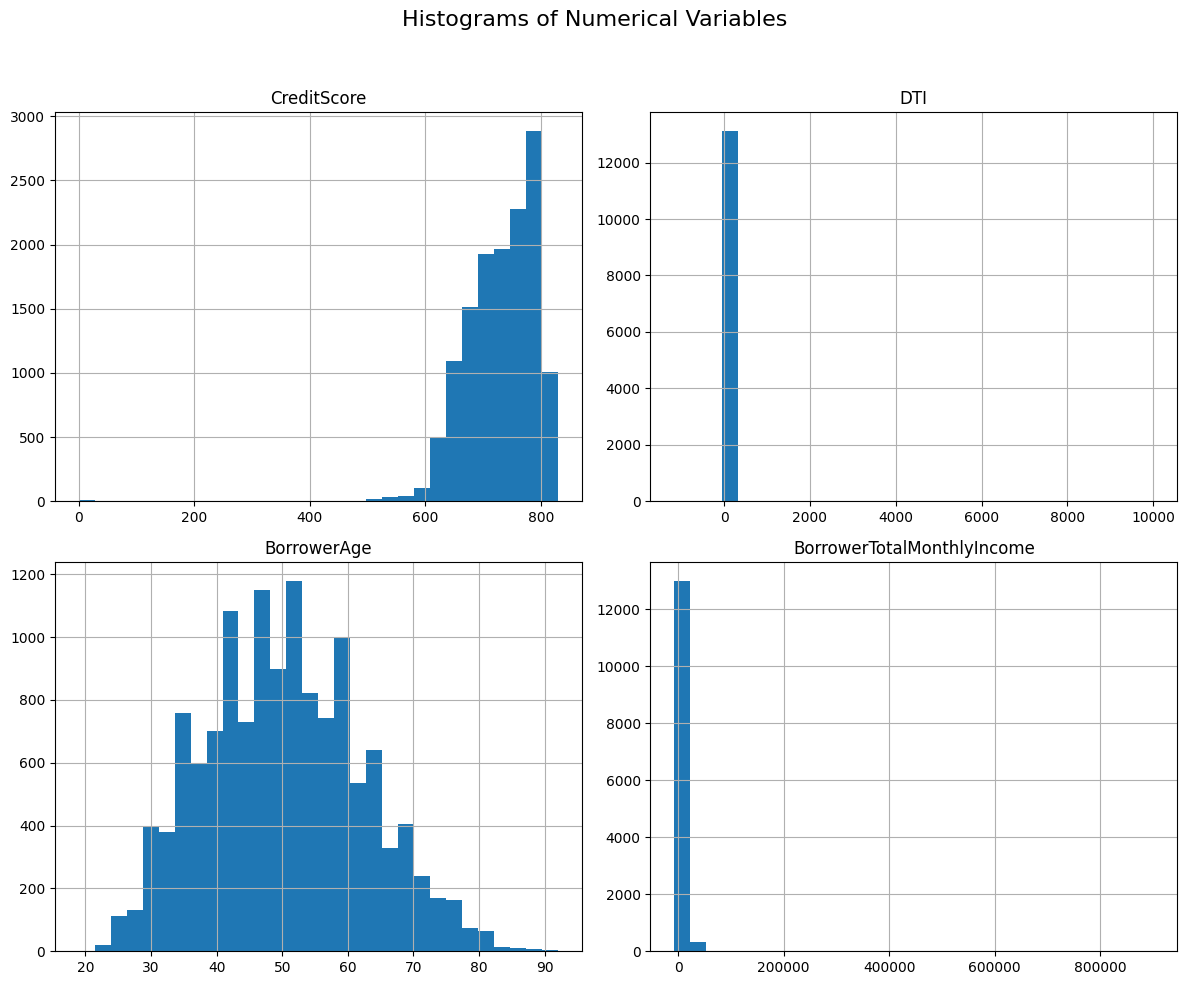

In [312]:
import matplotlib.pyplot as plt

# List of numerical variables
vars_num = ['CreditScore', 'DTI', 'BorrowerAge', 'BorrowerTotalMonthlyIncome']

# Create subplots with customized layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Histograms of Numerical Variables', fontsize=16)

# Plot histograms for each variable
for i, var in enumerate(vars_num):
    row = i // 2
    col = i % 2
    loan_original[var].hist(bins=30, ax=axes[row, col])
    axes[row, col].set_title(var)
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [313]:
loan_original.LoanPurpose.unique()

array(['Refinance', 'Refinance Cash-out', 'Purchase', 'VA IRRRL',
       'FHA Streamlined Refinance'], dtype=object)

In [314]:


#Recategorize Loan Purpose column
LP = ['Refinance','Purchase']
loan_original['LoanPurpose']= [v if v in LP else 'Refinance' for v in loan_original.LoanPurpose]

#Calculate difference between current date and DateAdded in days
loan_original['Diff']=pd.Timestamp.now().normalize()-loan_original['DateAdded'][loan_original.ApprovalDate.isna()]
loan_original['Diff']=[entry.days for entry in loan_original['Diff']]

loan_original['Approved']=['No' if ((x>=90) & (y=='Purchase')) else 'Yes' for (x,y) in zip(loan_original.Diff, loan_original.LoanPurpose)]
loan_original['Approved']=['No' if ((x>=45) & (y=='Refinance')) else 'Yes' for (x,y) in zip(loan_original.Diff, loan_original.LoanPurpose)]

#
loan_original['Approved']=loan_original['Approved'].astype('category')
loan_original['IsCoBorrowerower']=loan_original['IsCoBorrowerower'].astype('category')

loan_original.drop('Diff', axis=1, inplace=True)


LP = ['Own','Rent']
loan_original['BorrowerOwnRent']= [v if v in LP else 'Own' for v in loan_original.BorrowerOwnRent]
loan_original['BorrowerOwnRent'][loan_original['BorrowerOwnRent'].isna()]=loan_original['BorrowerOwnRent'].mode().values

loan_original.Approved.value_counts(normalize=True)

,proportion
Approved,
Yes,0.729416
No,0.270584


### Classes Proportion: We see that almost 73% loan applications were approved, and 27% loan applications were denied.

In [315]:
#Add Borrower & Co-Borrower's income
loan_original['TotalIncome']=loan_original.BorrowerTotalMonthlyIncome + loan_original.CoBorrowerTotalMonthlyIncome
# loan_original.drop(['BorrowerTotalMonthlyIncome','CoBorrowerTotalMonthlyIncome'],axis=1,inplace=True)

#Checck if Total income is 0

loan_original[((loan_original['TotalIncome']<0))]

#Regroup LeadSourceGroup
LSR = ['Internet', 'TV','Radio','Repeat Client' ]
loan_original['LeadSourceGroup'] = [v if v in LSR else 'Other' for v in loan_original.LeadSourceGroup]

zips = ['75', '76', '77', '78', '79']
loan_original['ZipCode'] = [str(zp)[:2] for zp in loan_original['ZipCode']]
loan_original['ZipCode'] = [v if v in zips else 'Other' for v in loan_original.ZipCode]






In [316]:
vars_num

['CreditScore', 'DTI', 'BorrowerAge', 'BorrowerTotalMonthlyIncome']

In [317]:
loan_original[(loan_original['TotalIncome'] <= 0) & (loan_original['DTI'] > 0)].shape

(5, 25)

# Impute missing values in DTI


In [318]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

print("Missing DTI count before imputation:", loan_original['DTI'].isna().sum())

# Select features for imputation (including DTI itself)
# features = ['DTI', 'CreditScore', 'CLTV', 'BorrowerAge','TotalIncome']
features = ['DTI','CreditScore','CLTV','BorrowerAge','BorrowerTotalMonthlyIncome','TotalLoanAmount','CoBorrowerTotalMonthlyIncome']

all_missing = loan_original[loan_original['DTI'].isna()][features].isna().all(axis=1).sum()

print("Rows with DTI missing AND all predictors missing before:", all_missing)

# Subset data
df_impute = loan_original[features].copy()

# Standardize features (important for KNN)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_impute)

# Apply KNN imputer (k=5 neighbors by default)
imputer = KNNImputer(n_neighbors=5)
df_imputed_scaled = imputer.fit_transform(df_scaled)

# Inverse transform back to original scale
df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed_scaled),
                          columns=features)

# Replace original DTI with imputed values
loan_original['DTI'] = df_imputed['DTI']

print("Missing DTI count after imputation:", loan_original['DTI'].isna().sum())
still_missing = loan_original[loan_original['DTI'].isna()][features].isna().all(axis=1).sum()

print("still_missing rows with DTI missing AND all predictors missing:", all_missing)

Missing DTI count before imputation: 222
Rows with DTI missing AND all predictors missing before: 0
Missing DTI count after imputation: 91
still_missing rows with DTI missing AND all predictors missing: 0


In [320]:
# Impute remaining missing values with median
loan_original['DTI'] = loan_original['DTI'].fillna(loan_original['DTI'].median())

print("Missing DTI count after imputation:", loan_original['DTI'].isna().sum())



Missing DTI count after imputation: 0
still_missing rows with DTI missing AND all predictors missing: 0


In [321]:

import numpy as np

# 1. Basic summary stats
print("Summary of DTI:")
print(loan_original['DTI'].describe())

# 2. Check negative values
neg_count = (loan_original['DTI'] < 0).sum()
print(f"\nNegative DTI count: {neg_count}")

# 3. Check extremely large values (say >400%)
extreme_count = (loan_original['DTI'] > 400).sum()
print(f"Extreme DTI count (>400): {extreme_count}")

# 4. Check income = 0 but DTI > 0 (likely invalid)
invalid_income = loan_original[(loan_original['TotalIncome'] <= 0) & (loan_original['DTI'] > 0)]
print(f"\nCases with income=0 but positive DTI: {invalid_income.shape[0]}")

# 5. Missing values
missing_count = loan_original['DTI'].isna().sum()
print(f"Missing DTI count: {missing_count}")

# 6. Top unusual values (outliers)
print("\nTop 10 highest DTI values:")
print(loan_original['DTI'].sort_values(ascending=False).head(10))


Summary of DTI:
count    13360.000000
mean        43.799820
std        242.138623
min      -1161.000000
25%         27.000000
50%         36.000000
75%         43.000000
max      10000.000000
Name: DTI, dtype: float64

Negative DTI count: 3
Extreme DTI count (>400): 30

Cases with income=0 but positive DTI: 228
Missing DTI count: 0

Top 10 highest DTI values:
13074    10000.0
12671    10000.0
12751    10000.0
13246    10000.0
12642    10000.0
12348    10000.0
13288    10000.0
10084     2047.8
12161     2045.6
10624     2043.6
Name: DTI, dtype: float64


In [322]:
# Cap DTI values greater than 500 to 500; Impute all DTI>=500 to 500 only
import numpy as np

# 1. Remove rows where income=0 but DTI>0 (invalid cases)
loan_original = loan_original[~((loan_original['BorrowerTotalMonthlyIncome'] <= 0) & (loan_original['DTI'] > 0))]

# 2. Cap extreme outliers at 400%
loan_original['DTI'] = loan_original['DTI'].clip(upper=400)

print("Max DTI after cleaning:", loan_original['DTI'].max())

# Check result
print("Max DTI after capping:", loan_original['DTI'].max())


Max DTI after cleaning: 400.0
Max DTI after capping: 400.0


In [323]:
nums_feats = ['TotalLoanAmount', 'CreditScore', 'CLTV', 'DTI','BorrowerAge', 'BorrowerYearsInSchool',
              'BorrowerTotalMonthlyIncome', 'CoBorrowerYearsInSchool', 'CoBorrowerAge','CoBorrowerTotalMonthlyIncome']


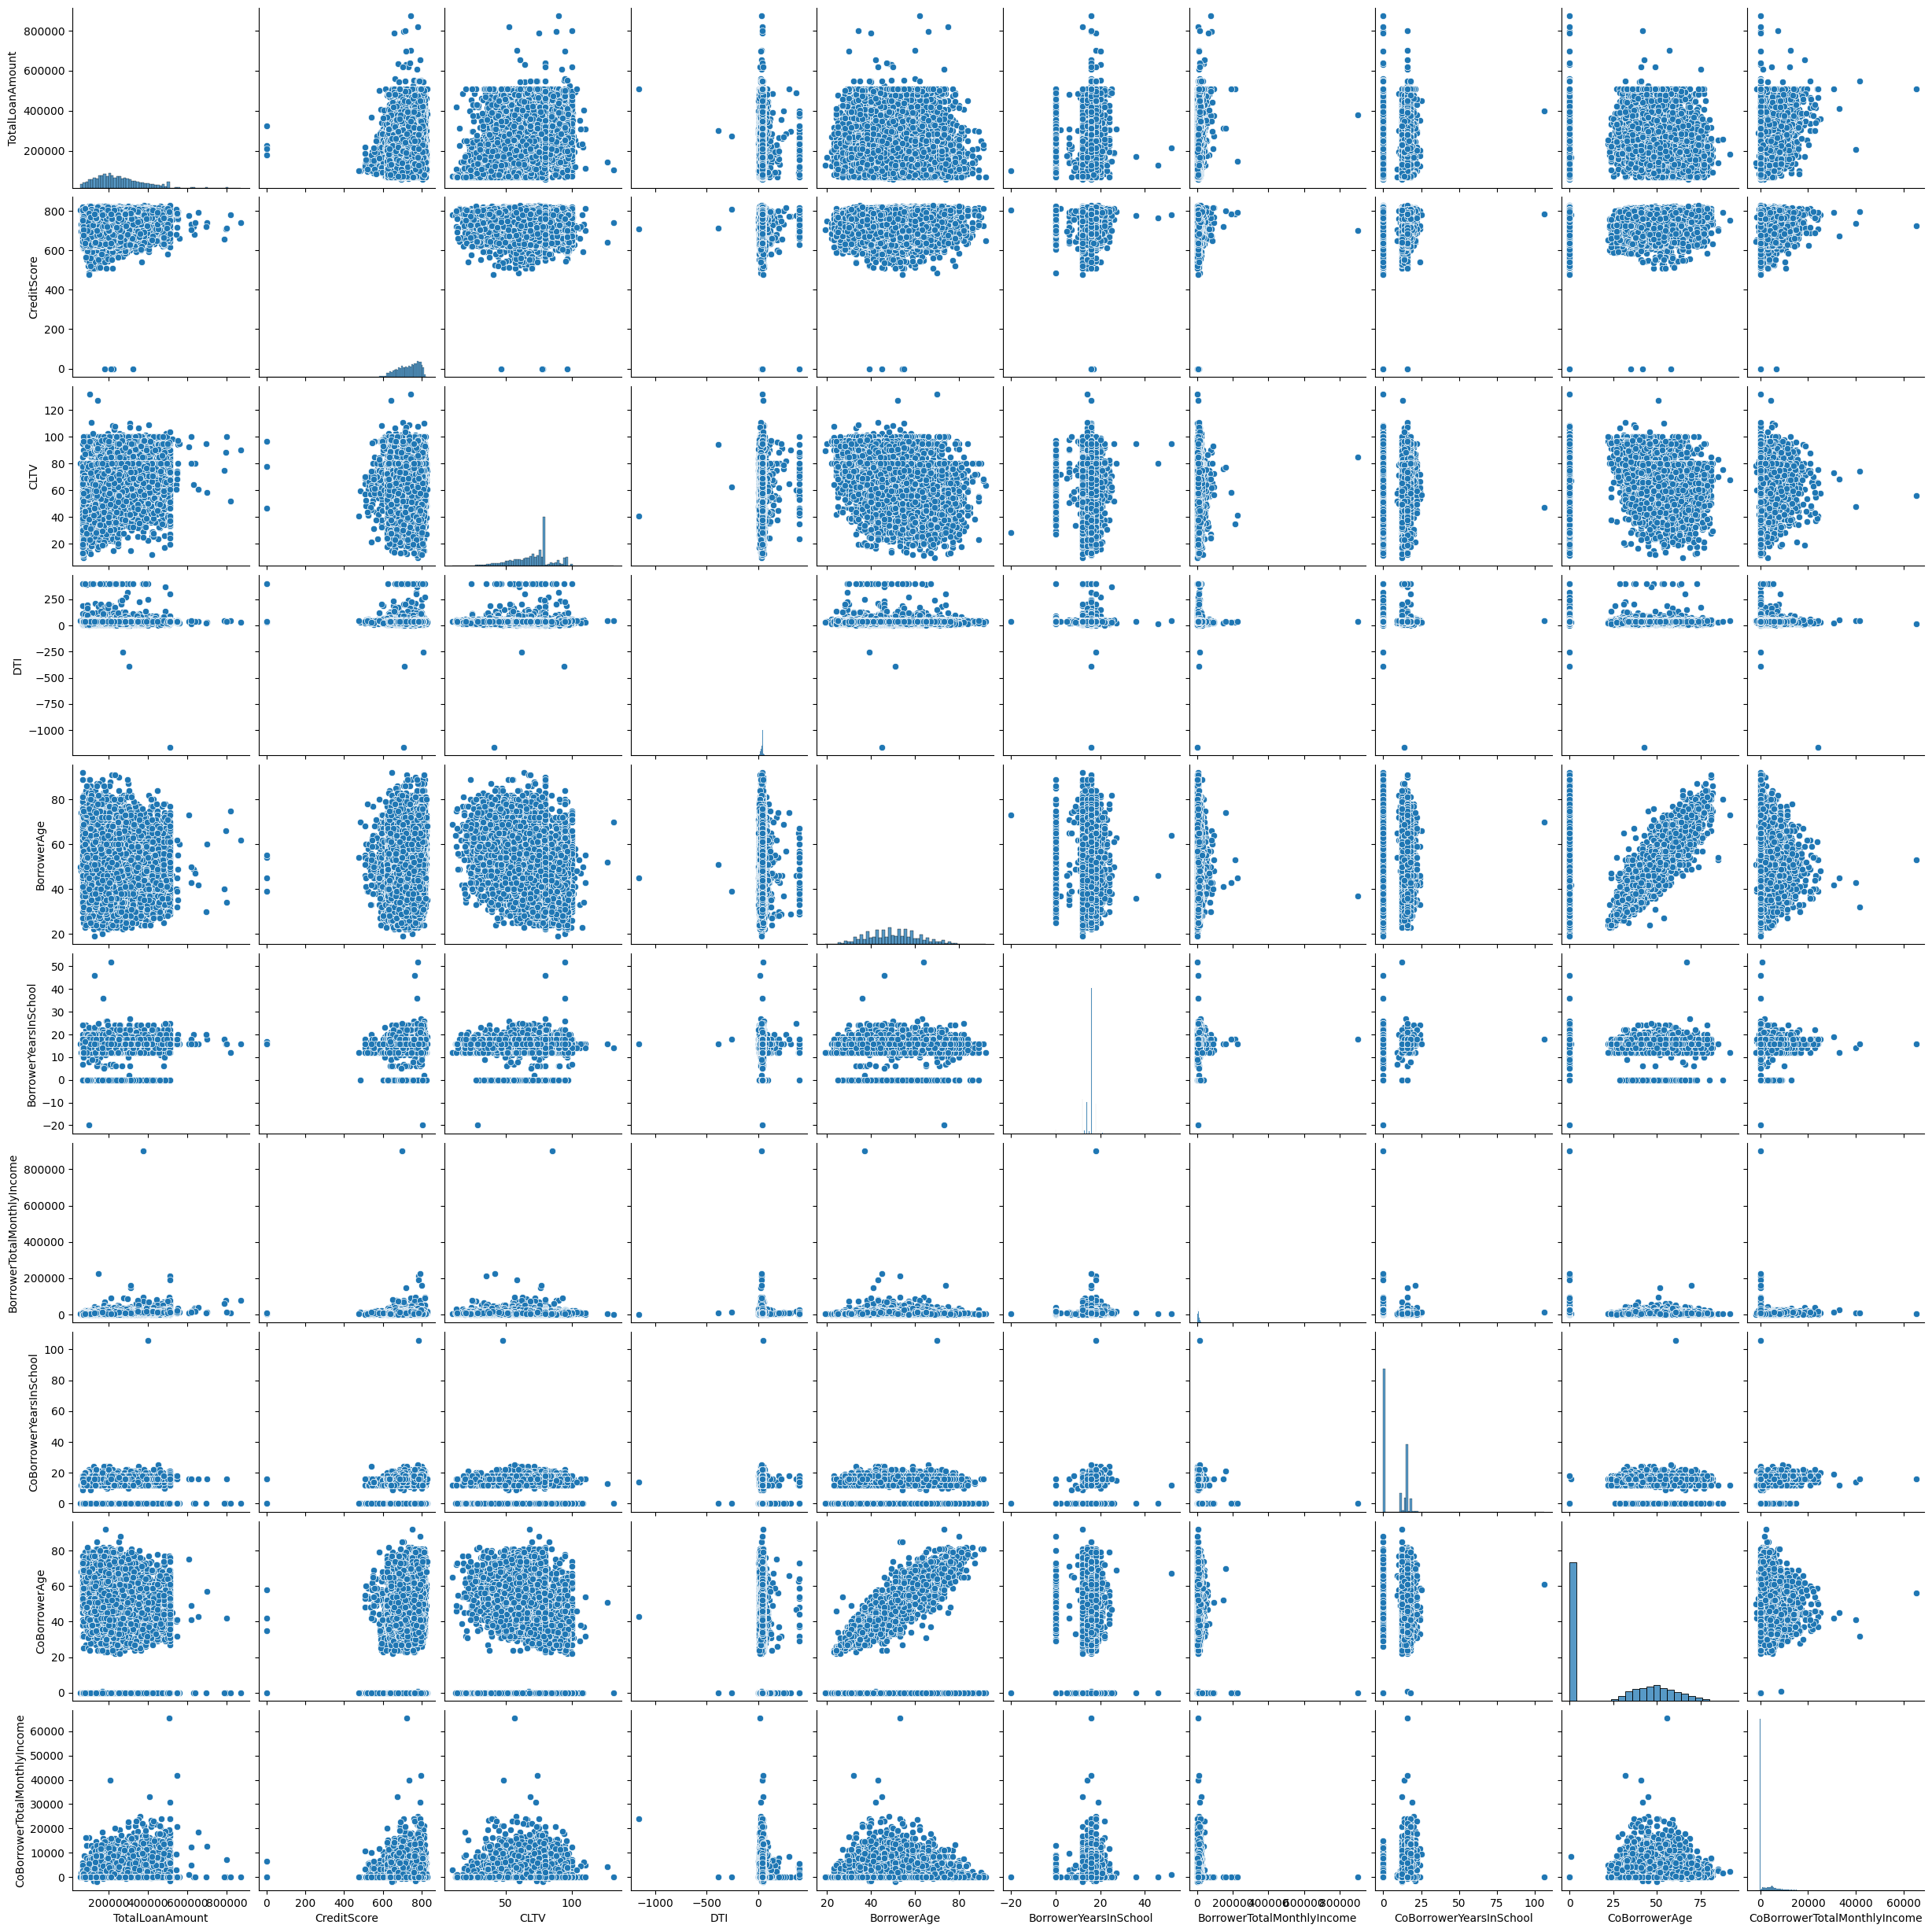

In [324]:
sns.pairplot(loan_original[nums_feats])

# Step 3: Univariate Analysis

## Step 3.1: Numerical variables Analysis

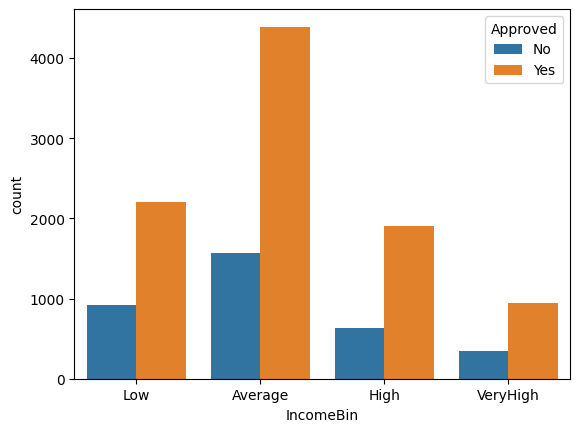

In [325]:
# Create bins
bins = [0, 5000, 10000, 15000, loan_original['BorrowerTotalMonthlyIncome'].max()]
group = ['Low', 'Average', 'High', 'VeryHigh']
loan_original['IncomeBin'] = pd.cut(loan_original['BorrowerTotalMonthlyIncome'], bins, labels=group)

# Use seaborn countplot
sns.countplot(x='IncomeBin', data=loan_original, hue='Approved')
# Show the plot
plt.show()

In [327]:
# Count approvals and total per bin
acceptance_rate = (
    loan_original
    .groupby('IncomeBin')
    .apply(lambda x: (x['Approved'] == 'Yes').mean())  # or (x['LoanStatus'] == 1).mean()
    .reset_index(name='AcceptanceRate')
)

print(acceptance_rate)


  IncomeBin  AcceptanceRate
0       Low        0.706146
1   Average        0.737567
2      High        0.750887
3  VeryHigh        0.730171


# Verdict: Our hypothesis that Applicants with high incomes should have more chances of loan approval holds true.


<Axes: xlabel='BorrowerAge', ylabel='Density'>

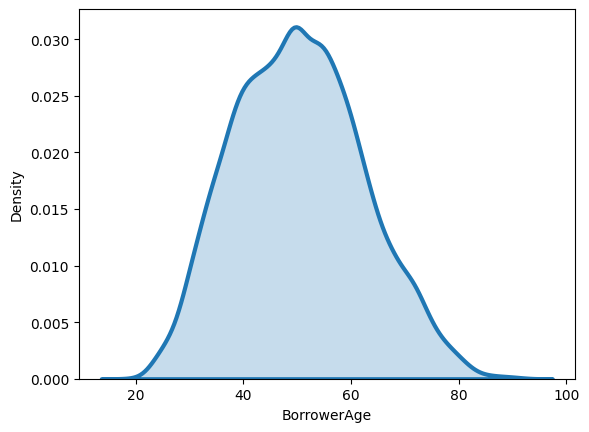

In [328]:
sns.distplot(loan_original['BorrowerAge'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3})

<Axes: xlabel='BorrowerYearsInSchool', ylabel='Density'>

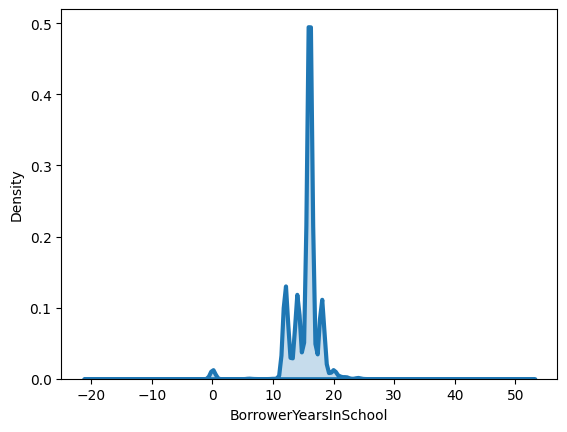

In [329]:
sns.distplot(loan_original['BorrowerYearsInSchool'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3})

<Axes: xlabel='Education', ylabel='count'>

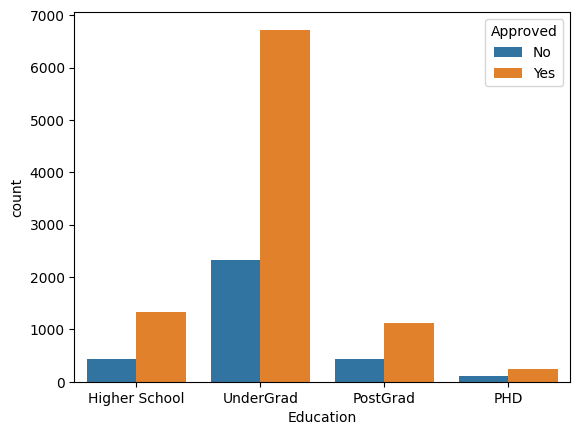

In [330]:
#Create bins for Education
bins=[0,12,16,18,loan_original.BorrowerYearsInSchool.max()]
group=['Higher School','UnderGrad','PostGrad','PHD']
loan_original['Education']=pd.cut(loan_original['BorrowerYearsInSchool'],bins,labels=group)
sns.countplot(x='Education',data=loan_original,hue='Approved')



In [331]:
# Count approvals and total per bin
acceptance_rate = (
    loan_original
    .groupby('Education')
    .apply(lambda x: (x['Approved'] == 'Yes').mean())  # or (x['LoanStatus'] == 1).mean()
    .reset_index(name='AcceptanceRate')
)

print(acceptance_rate)


       Education  AcceptanceRate
0  Higher School        0.753129
1      UnderGrad        0.743584
2       PostGrad        0.718651
3            PHD        0.678771


In [332]:
print(f"Number of records with negative values : {loan_original[loan_original.DTI < 0].shape[0]}")
loan_original = loan_original[loan_original['DTI'] >= 0].copy()


Number of records with negative values : 3


In [333]:
loan_original['DTI'].describe()

,DTI
count,12897.000000
mean,36.377933
std,22.708034
min,0.000000
25%,27.000000
50%,36.000000
75%,43.000000
max,400.000000


In [334]:
loan_original['DTI'].value_counts(ascending=False)

,count
DTI,
44.0,693
43.0,533
42.0,529
41.0,497
36.0,492
...,...
88.6,1
112.0,1
48.4,1


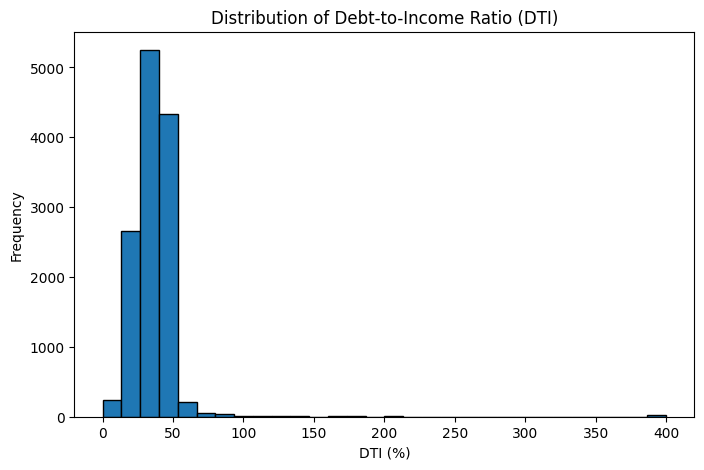

In [335]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(loan_original['DTI'].dropna(), bins=30, edgecolor='black')
plt.title("Distribution of Debt-to-Income Ratio (DTI)")
plt.xlabel("DTI (%)")
plt.ylabel("Frequency")
plt.show()


In [336]:
import pandas as pd
import numpy as np

# 1) Make fine DTI bins
bins = list(range(0, 101, 5))  # 0–5, 5–10, ..., 95–100
loan_original['DTI_FineBin'] = pd.cut(loan_original['DTI'], bins=bins, include_lowest=True)

# 2) Coerce Approved -> numeric 1/0
# Try common patterns; fall back to to_numeric
if loan_original['Approved'].dtype == bool:
    loan_original['Approved_num'] = loan_original['Approved'].astype(int)
else:
    # Map common string labels; adjust if your labels differ
    mapping = {
        'Approved': 1, 'approved': 1, 'Yes': 1, 'Y': 1, '1': 1, 1: 1,
        'Rejected': 0, 'rejected': 0, 'No': 0, 'N': 0, '0': 0, 0: 0
    }
    loan_original['Approved_num'] = (
        loan_original['Approved']
        .map(mapping)
        .pipe(lambda s: pd.to_numeric(s, errors='coerce'))
        .astype('float')  # keep float so mean works; you can astype(int) later if needed
    )

# 3) Compute acceptance rate per fine bin
acceptance_by_finebin = (
    loan_original
    .groupby('DTI_FineBin', observed=True)['Approved_num']
    .mean()
    .reset_index(name='AcceptanceRate')
)

# (Optional) also include counts to assess stability
counts_by_finebin = (
    loan_original
    .groupby('DTI_FineBin', observed=True)['Approved_num']
    .agg(TotalApps='count', ApprovedApps=lambda s: int(np.nansum(s)))
    .reset_index()
)

print(acceptance_by_finebin.head(20))
print(counts_by_finebin.head(20))


      DTI_FineBin  AcceptanceRate
0   (-0.001, 5.0]        0.666667
1     (5.0, 10.0]        0.656250
2    (10.0, 15.0]        0.721893
3    (15.0, 20.0]        0.715182
4    (20.0, 25.0]        0.701754
5    (25.0, 30.0]        0.712544
6    (30.0, 35.0]        0.755729
7    (35.0, 40.0]        0.730266
8    (40.0, 45.0]        0.747486
9    (45.0, 50.0]        0.738233
10   (50.0, 55.0]        0.756477
11   (55.0, 60.0]        0.802083
12   (60.0, 65.0]        0.780488
13   (65.0, 70.0]        0.888889
14   (70.0, 75.0]        0.760000
15   (75.0, 80.0]        0.562500
16   (80.0, 85.0]        0.500000
17   (85.0, 90.0]        0.687500
18   (90.0, 95.0]        0.666667
19  (95.0, 100.0]        0.285714
      DTI_FineBin  TotalApps  ApprovedApps
0   (-0.001, 5.0]         12             8
1     (5.0, 10.0]         64            42
2    (10.0, 15.0]        338           244
3    (15.0, 20.0]        797           570
4    (20.0, 25.0]       1368           960
5    (25.0, 30.0]       1722

In [337]:
bins = [0, 30, 50, 80, loan_original['DTI'].max()]
labels = ['Low (0-30)', 'Moderate (30-50)', 'High (50-80)', 'Risky (80+)']

loan_original['DTI_Bin'] = pd.cut(
    loan_original['DTI'], bins=bins, labels=labels, include_lowest=True
)

acceptance_by_bin = (
    loan_original.groupby('DTI_Bin')['Approved_num']
    .mean()
    .reset_index(name='AcceptanceRate')
)

print(acceptance_by_bin)


            DTI_Bin  AcceptanceRate
0        Low (0-30)        0.709370
1  Moderate (30-50)        0.743459
2      High (50-80)        0.771357
3       Risky (80+)        0.631579


In [338]:

catVars=['LeadSourceGroup','LoanType','LoanPurpose', 'Education','BorrowerOwnRent','ZipCode','LoanOfficer']
numVars=['TotalLoanAmount','CreditScore','CLTV', 'DTI','BorrowerAge',
       'TotalIncome']

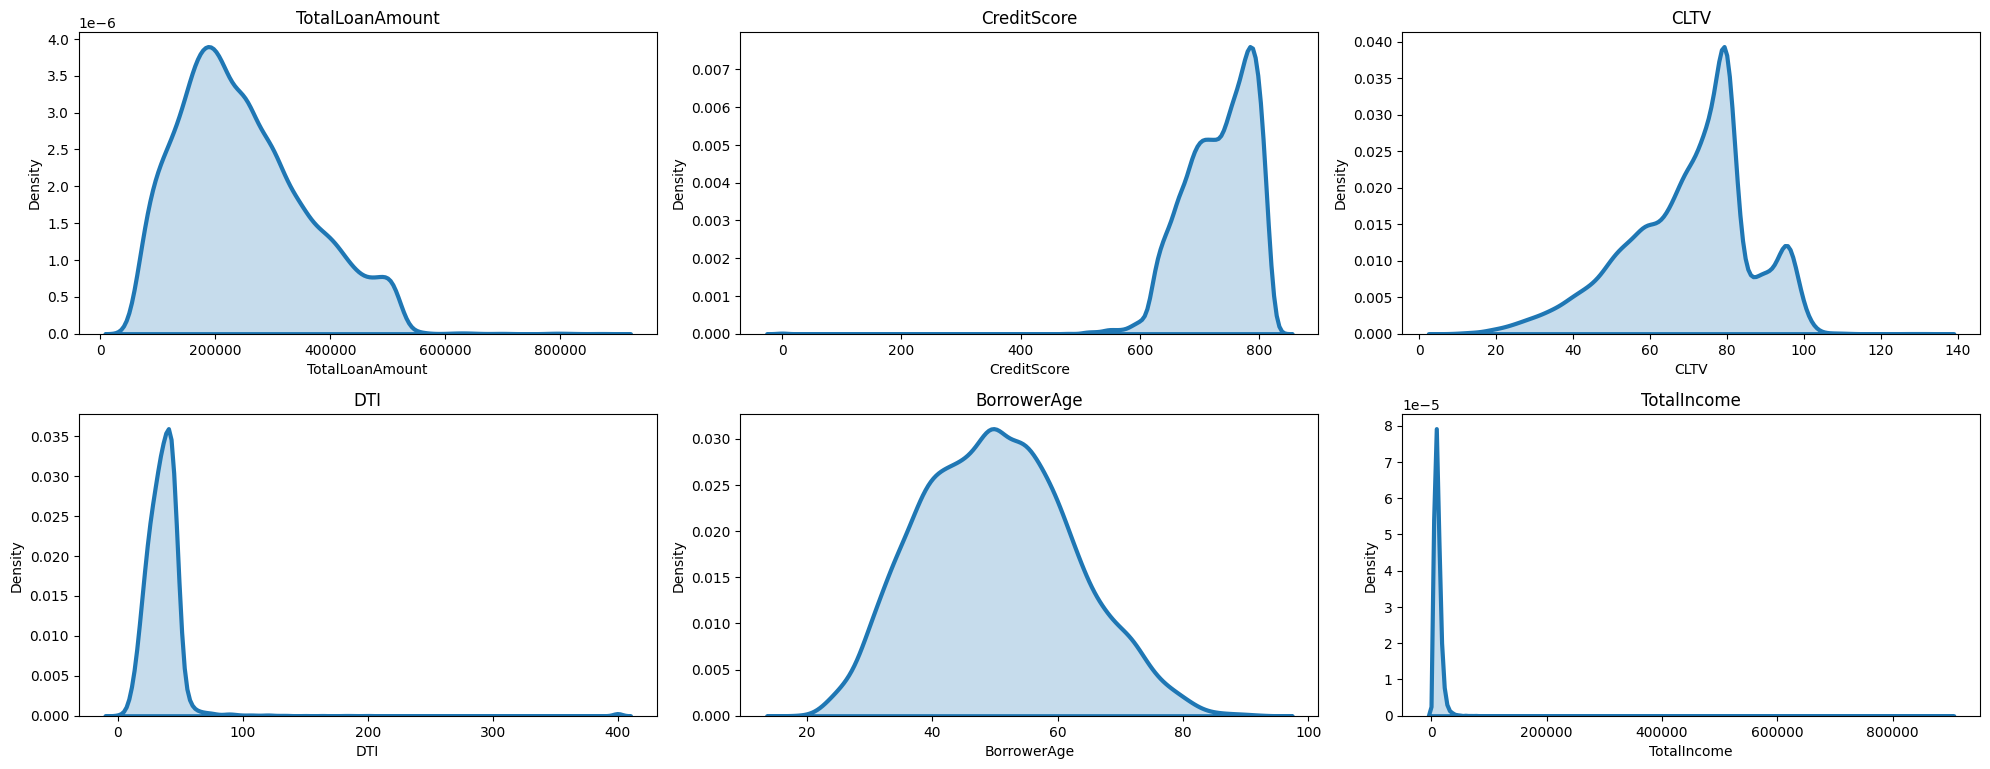

In [339]:
### Check distribution of all numerical features
plt.figure(figsize=(20,15), facecolor='white')
# plot numbering starts at 1, not 0
plot_number = 1
for  col in numVars:
    # Inside of an image that's a 15x13 grid, put this
    # graph in the in the plot_number slot.
    ax = plt.subplot(4, 3, plot_number)
    sns.distplot(loan_original[col], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3})
    ax.set_title(col)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

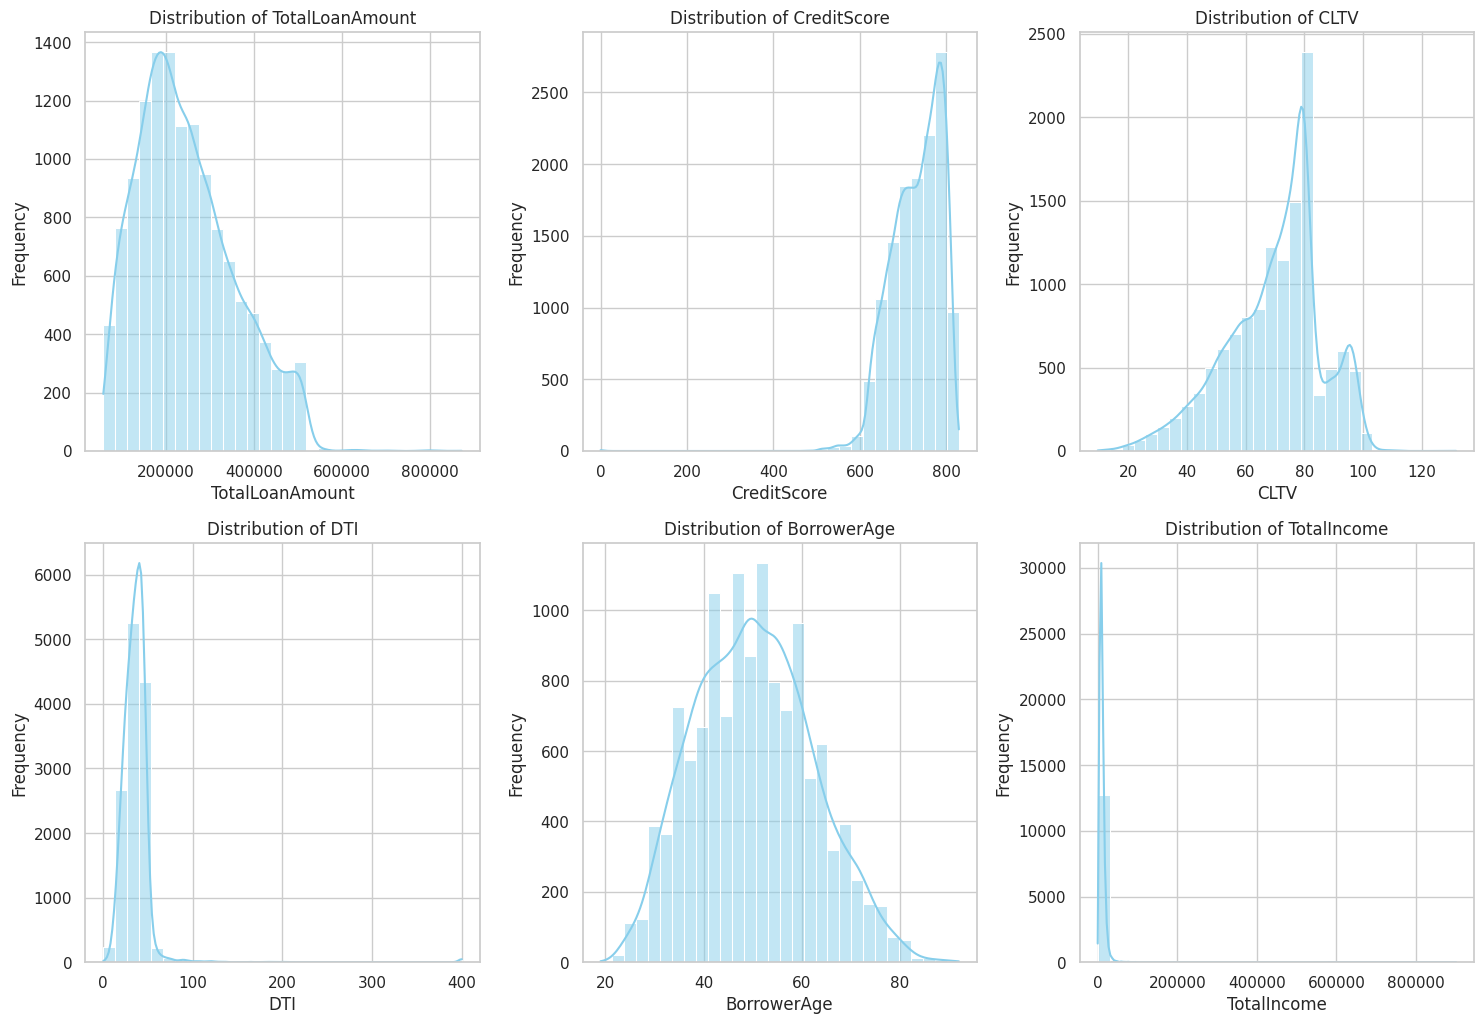

In [340]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, for additional styling

# Assuming 'loan_data' is your DataFrame and numVars is the list of numerical variables
# Replace 'loan_data' and 'numVars' with the actual names in your dataset.

# Set the style (optional, for better visualization)
sns.set(style="whitegrid")

# List of numerical variables
num_vars = ['TotalLoanAmount', 'CreditScore', 'CLTV', 'DTI', 'BorrowerAge', 'TotalIncome']

# Create subplots in a 3x3 grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Flatten the 2D array of subplots into a 1D array
axes = axes.flatten()

# Plot histograms for each numerical variable
for i, var in enumerate(num_vars):
    sns.histplot(loan_original[var], bins=30, kde=True, color='skyblue', ax=axes[i])

    # Add labels and title
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

# Remove empty subplots if there are fewer than 9 variables
for j in range(len(num_vars), 9):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Inference:-
TotalLoanAmount & BorrowerAge have good distribution in comparison with other features.
Most of the applicants are in the age of 50.
CoBorrowerAge has got bimodal distribution ,one is centered around 0 and another is centered around 50. There seems to some problem with this feature.
CoBorrowerYearsInSchool has got bimodal distribution ,one is centered around 0 and another is centered around 14. There seems to some problem with this feature.


# Analysis:
**A. Total Loan Amount:**
  If the distribution of loan amounts is right-skewed, it means that the majority of loan amounts are concentrated on the lower end, and there are fewer instances of higher loan amounts. Here are some inferences you can draw:


1. **Most Loans are Small:** The peak of the distribution (mode) is likely to be on the left side, indicating that most loans have relatively smaller amounts. This could suggest that a significant proportion of the loans granted are for lower amounts.

2. **Fewer Large Loans:** The right tail of the distribution is longer, indicating that there are fewer instances of larger loan amounts. This might suggest that there are fewer borrowers or instances where substantial loan amounts are requested or approved.

3. **Potential Outliers:** Right-skewness often implies the presence of outliers on the higher end. Outliers could be instances where the loan amount is significantly larger than the majority of the loans. These outliers might be worth investigating further, as they could represent unique or special cases.

4. **Income Disparities:** A right-skewed distribution might reflect income disparities among the borrowers. It could indicate that a large proportion of borrowers have lower incomes and are requesting smaller loan amounts, while a smaller group of borrowers may have higher incomes and are eligible for larger loan amounts.

5. **Risk Assessment:** From a lending perspective, a right-skewed distribution might influence risk assessment. It suggests that the majority of borrowers are seeking smaller loans, which could be less risky. However, the presence of outliers implies that there might be higher-risk loans that need closer scrutiny.

In any data analysis, it's important to consider the context of the data and the specific characteristics of the population being studied. Exploring the reasons behind the observed distribution and understanding the implications for decision-making are crucial steps in drawing meaningful inferences.



**B. Credit Score:**
If the distribution of Credit Scores is left-skewed with a long left tail, several inferences can be made about the data:

1. **Majority of Scores are Higher:**
   - The peak of the distribution is on the right side, indicating that the majority of credit scores are higher. This could mean that a significant portion of the population has relatively good credit.

2. **Fewer Instances of Low Credit Scores:**
   - The long left tail suggests that there are fewer instances of very low credit scores. This could indicate that a smaller proportion of individuals in the dataset have poor credit.

3. **Potential Outliers on the Low End:**
   - The left tail also suggests the presence of outliers or extreme values on the lower end of the credit score spectrum. These outliers could represent individuals with exceptionally low credit scores.

4. **Skewed Distribution:**
   - The skewness to the left indicates that the distribution is not symmetrical. This might be due to factors such as economic conditions, lending practices, or other external influences that cause a concentration of higher credit scores.

5. **Positive Skewness:**
   - The left skewness implies a positive skewness, indicating that the mean is likely greater than the median. In other words, the average credit score might be higher than the middle point of the distribution.

6. **Potential Need for Transformation:**
   - Depending on the analysis and modeling techniques, the left-skewed distribution may benefit from transformation (e.g., logarithmic or square root) to make it more symmetrical and meet the assumptions of certain statistical methods.

7. **Creditworthiness of the Population:**
   - The distribution suggests that a significant portion of the population has good creditworthiness, but there are still individuals with lower credit scores. This information could be valuable for financial institutions or businesses that use credit scores for decision-making.

It's essential to consider the context of the data and the specific goals of the analysis when interpreting the characteristics of the distribution. Additionally, further exploration and analysis may be needed to understand the factors contributing to the observed credit score distribution.




**C. CLTV:**
If the distribution of Customer Lifetime Value (CLTV) is left-skewed when visualized using `sns.distplot` (a seaborn function for plotting distributions), it implies that the majority of customers have lower CLTV values, with a tail extending towards higher values. Here are some potential inferences you can draw:

1. **Majority of Customers have Lower CLTV:**
   - The peak of the distribution is towards the lower end of CLTV values, indicating that most customers have relatively lower lifetime values.

2. **Potential Outliers with High CLTV:**
   - The left skewness suggests the presence of a few customers with significantly higher CLTV values, appearing as outliers. These customers contribute to the tail on the higher end of the distribution.

3. **Varied Customer Segments:**
   - The distribution might indicate the existence of distinct segments within the customer base. The majority of customers may fall into one segment with lower CLTV, while a smaller segment may exhibit higher CLTV.

4. **Potential for Targeted Marketing:**
   - Businesses may consider targeting marketing efforts towards the segment with lower CLTV to improve customer retention and increase their lifetime value.

5. **Opportunity for Improvement:**
   - If the goal is to increase overall CLTV, businesses may need to explore strategies to enhance customer loyalty, engagement, and satisfaction, particularly within the segment showing lower CLTV.

6. **Understanding Customer Behavior:**
   - Left-skewed distributions might indicate that customers tend to make a few high-value transactions but are less likely to remain engaged over an extended period.

7. **Consideration for Business Strategy:**
   - The left-skewed CLTV distribution may influence strategic decisions related to resource allocation, marketing budgeting, and customer relationship management.

It's important to note that the interpretation of the distribution should be done in the context of the specific business and its goals. Additionally, examining the underlying factors contributing to the distribution and considering external variables can provide a more comprehensive understanding of customer behavior and CLTV patterns.




**D. DTI:**
If the Seaborn `sns.distplot` for Debt-to-Income Ratio (DTI) is right-skewed with a long tail on the right side, several inferences can be made about the distribution of the data. Here are some interpretations:

1. **Positive Skewness:**
   - The distribution is positively skewed, meaning that the majority of the data points have lower DTI values, but there is a long tail towards higher DTI values.
   - This suggests that a significant portion of the population has lower debt-to-income ratios, which is generally considered favorable.

2. **Outliers:**
   - The long tail on the right side indicates the presence of outliers with higher DTI values. These outliers might represent individuals or cases with exceptionally high debt relative to their income.

3. **Potential Financial Risk:**
   - High DTI values are often associated with financial risk, as they indicate a larger proportion of income being used to cover debt obligations. The presence of a long tail on the right side may suggest that there is a subset of the population facing higher financial risk.

4. **Income Disparities:**
   - The skewness in the distribution may also suggest income disparities, with a significant portion of the population having lower incomes and consequently lower DTI values, while a smaller group has higher incomes and higher DTI values.

5. **Possible Need for Financial Education or Assistance:**
   - The distribution could indicate a need for financial education or assistance for those with higher DTI values, as they may be at a higher risk of financial strain or difficulty in managing their debt.

6. **Lending and Credit Risk:**
   - For financial institutions, a right-skewed distribution may imply that a majority of their clients have manageable DTI ratios, but there is a smaller subset with higher DTI values that could pose a higher credit risk.

7. **Policy Implications:**
   - Policymakers might consider addressing income disparities or implementing targeted interventions to assist individuals with high DTI values, especially if there is a substantial portion of the population affected.

It's important to note that these inferences are based on the assumption that DTI follows a right-skewed distribution. The interpretation may vary depending on the context of the data and the specific characteristics of the population under consideration.




**E. Total Income:**
If the distribution of Total Income is right-skewed with a long tail on the right side, there are several inferences you can draw:

1. **Positive Skewness:** The fact that the distribution is right-skewed indicates that there is a tail on the right side of the distribution. This implies that there are a few high-income individuals or cases that contribute to the skewness. The majority of the data points are likely clustered towards the lower end of the income scale.

2. **Outliers or High-Income Individuals:** The long tail on the right side suggests the presence of outliers or individuals with significantly higher incomes than the rest of the population. These outliers can have a substantial impact on the mean of the distribution, pulling it towards higher values.

3. **Income Inequality:** The right-skewed distribution implies income inequality, where a small proportion of the population has much higher incomes than the majority. This could be an indication of a wealth gap within the studied population.

4. **Log Transformation Consideration:** In cases where the distribution is highly right-skewed, it might be beneficial to consider log-transforming the data. This can help in reducing the impact of extreme values and make the distribution more symmetric.

5. **Median vs. Mean:** Due to the skewness, the mean (average) income may be higher than the median income. The median is a more robust measure of central tendency in skewed distributions as it is less affected by extreme values.

6. **Financial Planning Considerations:** Understanding the skewness of income distribution is important for financial planning and policy-making. It helps identify the income levels of the majority of the population as well as the potential challenges associated with high-income individuals.

7. **Tail Analysis:** Examining the long tail on the right side can provide insights into the extent of the income disparities. It might be interesting to investigate the specific characteristics of individuals in the high-income bracket and understand the factors contributing to their outlier status.

In summary, a right-skewed distribution with a long tail on the right side indicates income inequality, the presence of outliers, and suggests a need for careful analysis when using the mean as a measure of central tendency.



In [341]:
## Filter out extreme outliers

loan_original=loan_original[loan_original.CLTV<110]
loan_original=loan_original[loan_original.TotalLoanAmount<600000]
loan_original=loan_original[loan_original.CreditScore>550]
loan_original=loan_original[loan_original.TotalIncome<=30000]

## Step 3.2: Categorical variables Analysis

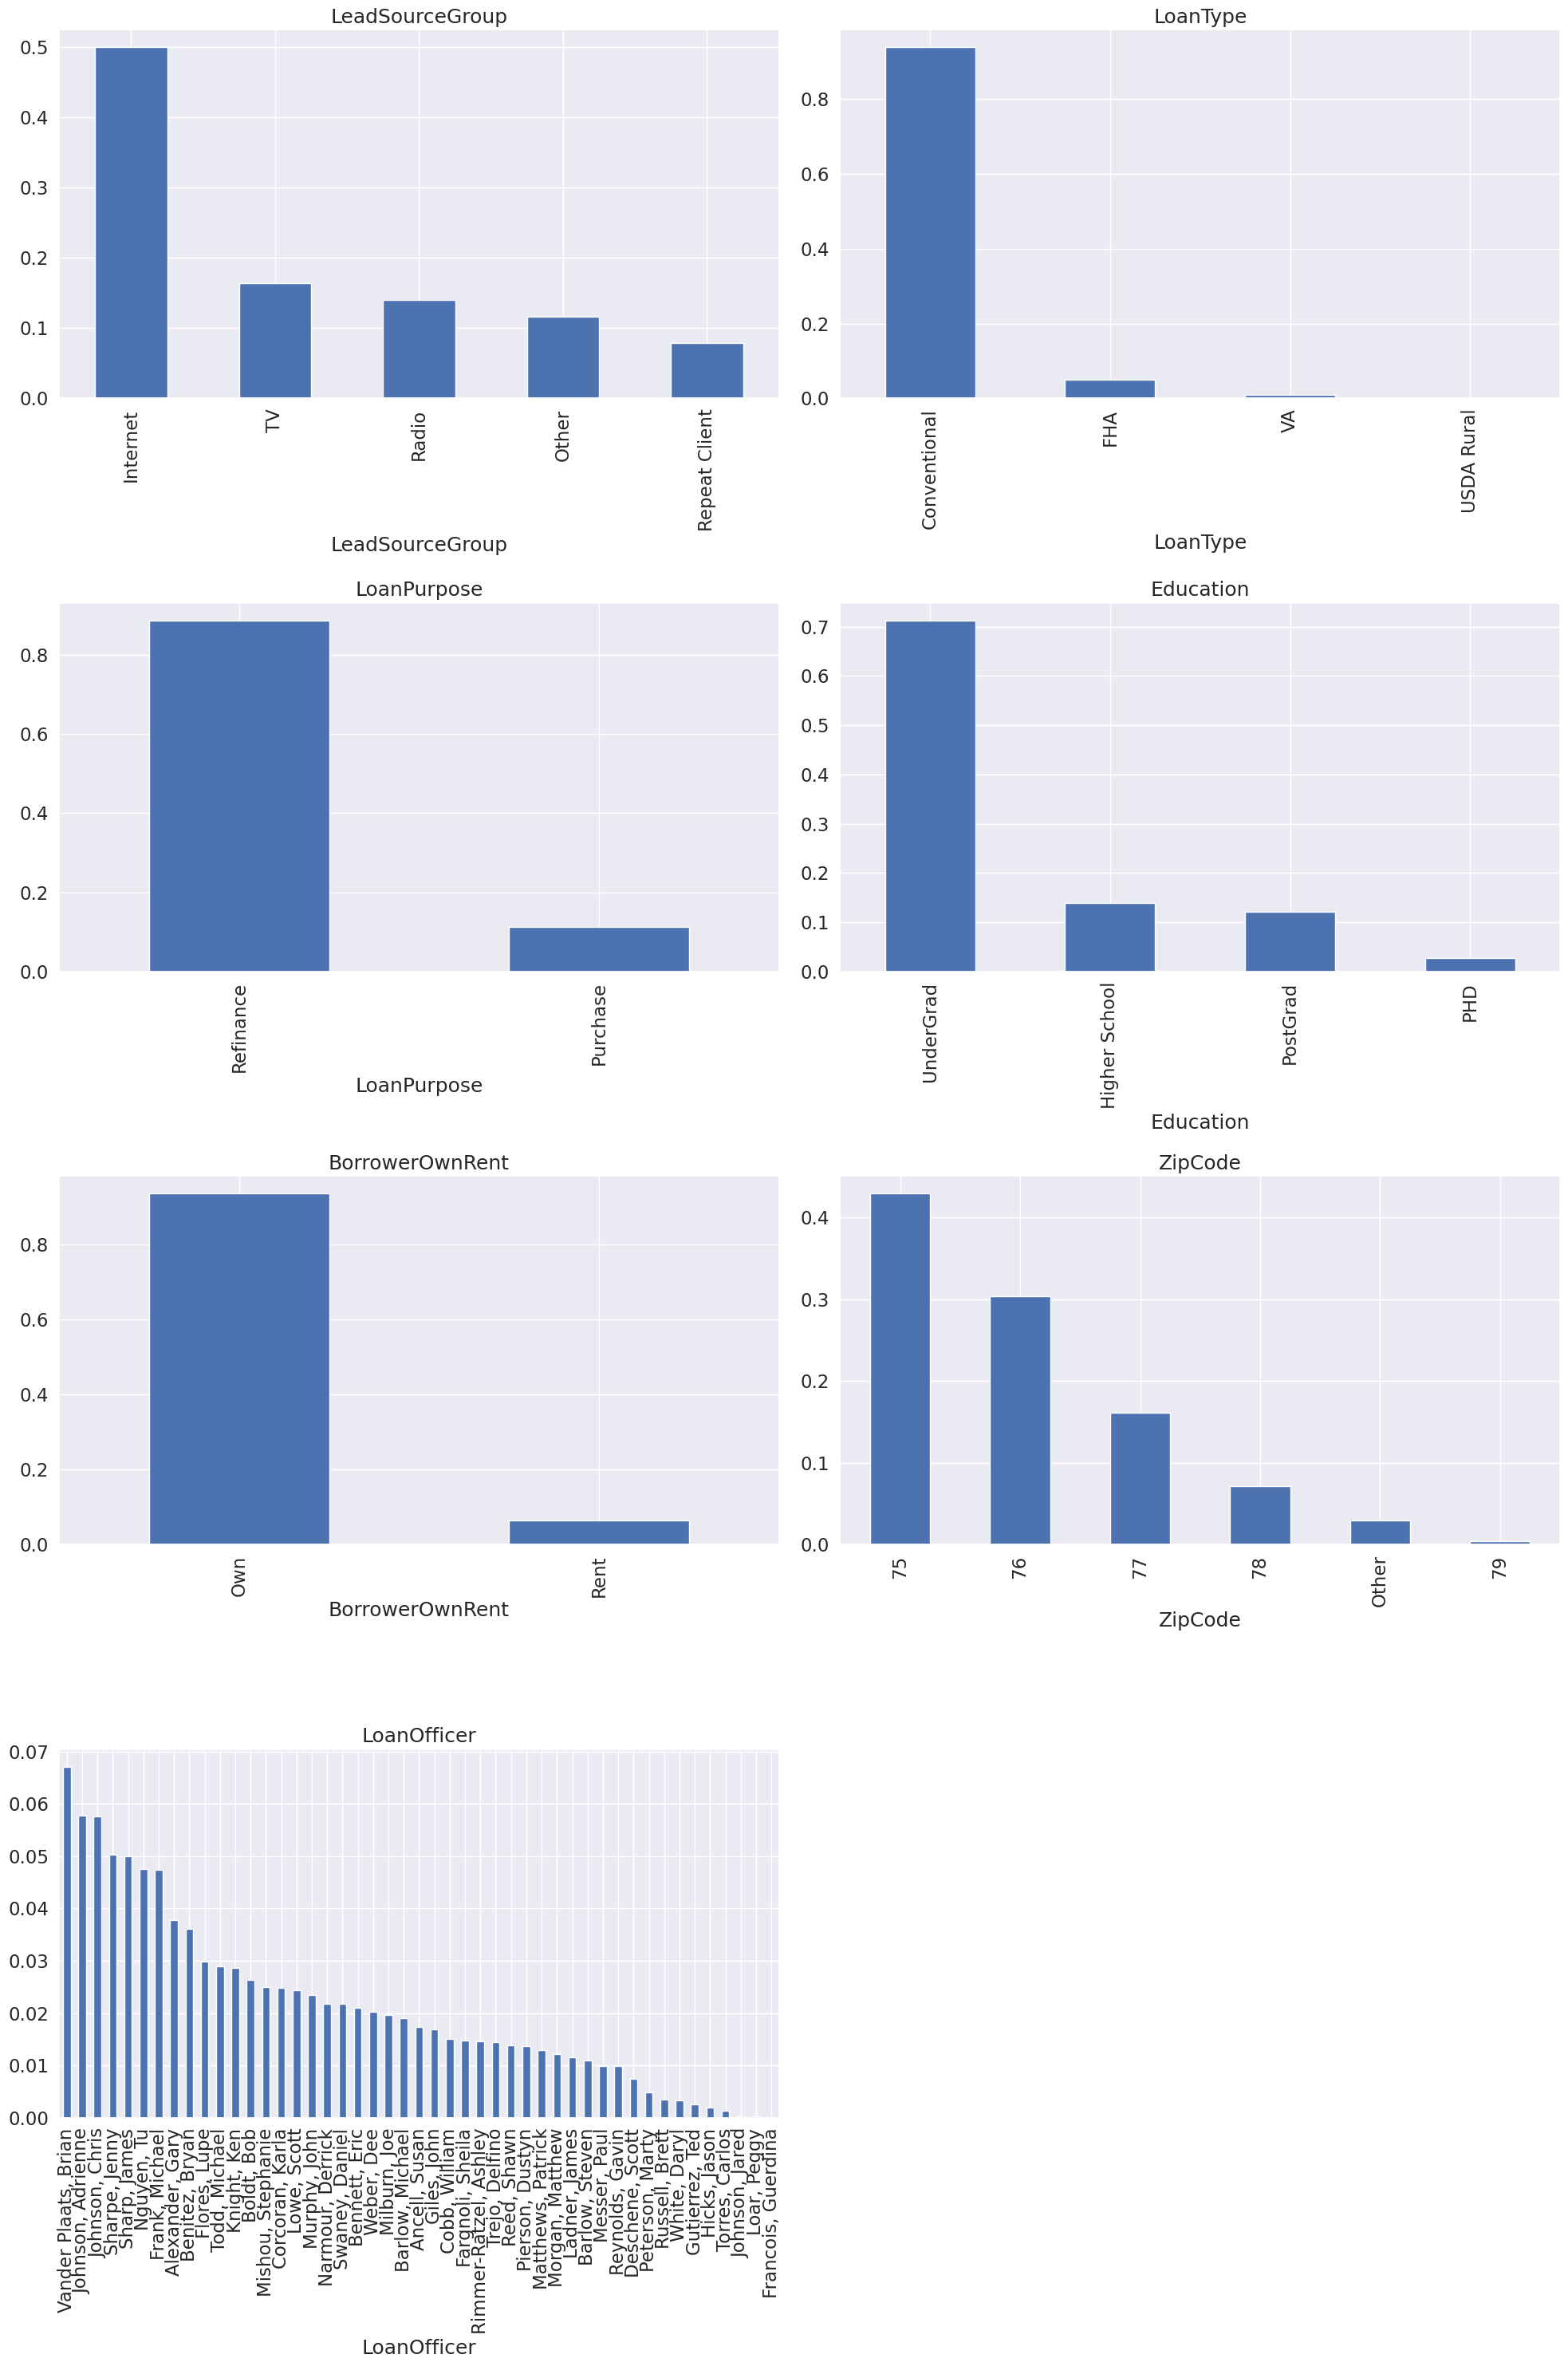

In [342]:
#Check distribution of all categorical variables
sns.set(font_scale=1.5)
### Check distribution of all features
plt.figure(figsize=(20,30), facecolor='white')
# plot numbering starts at 1, not 0
plot_number = 1
for  col in catVars:
    # Inside of an image that's a 15x13 grid, put this
    # graph in the in the plot_number slot.
    ax = plt.subplot(4, 2, plot_number)
    loan_original[col].value_counts(normalize=True).plot(kind='bar')
    ax.set_title(col)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

# Step 4. Bivariate Analysis
4.1 Categorical Independent Variables vs Target Variable

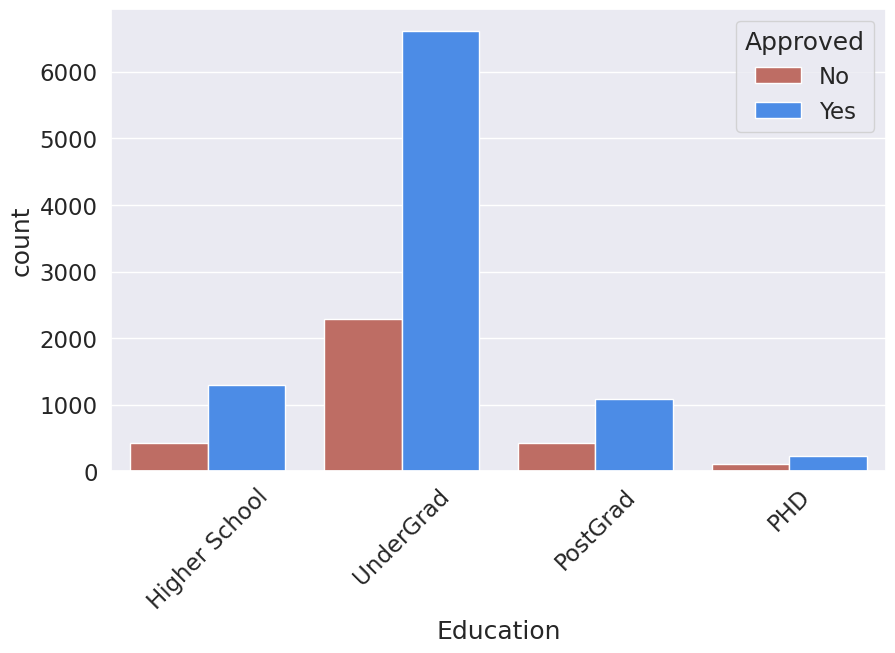

In [343]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming loan_original is your DataFrame

# Set up the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

# Create the countplot with tilted x-axis labels
sns.countplot(x='Education', data=loan_original, hue='Approved', palette=['#CD6155', '#3388FF'])

# Tilt x-axis labels
plt.xticks(rotation=45)  # Adjust the rotation angle as needed

# Show the plot
plt.show()

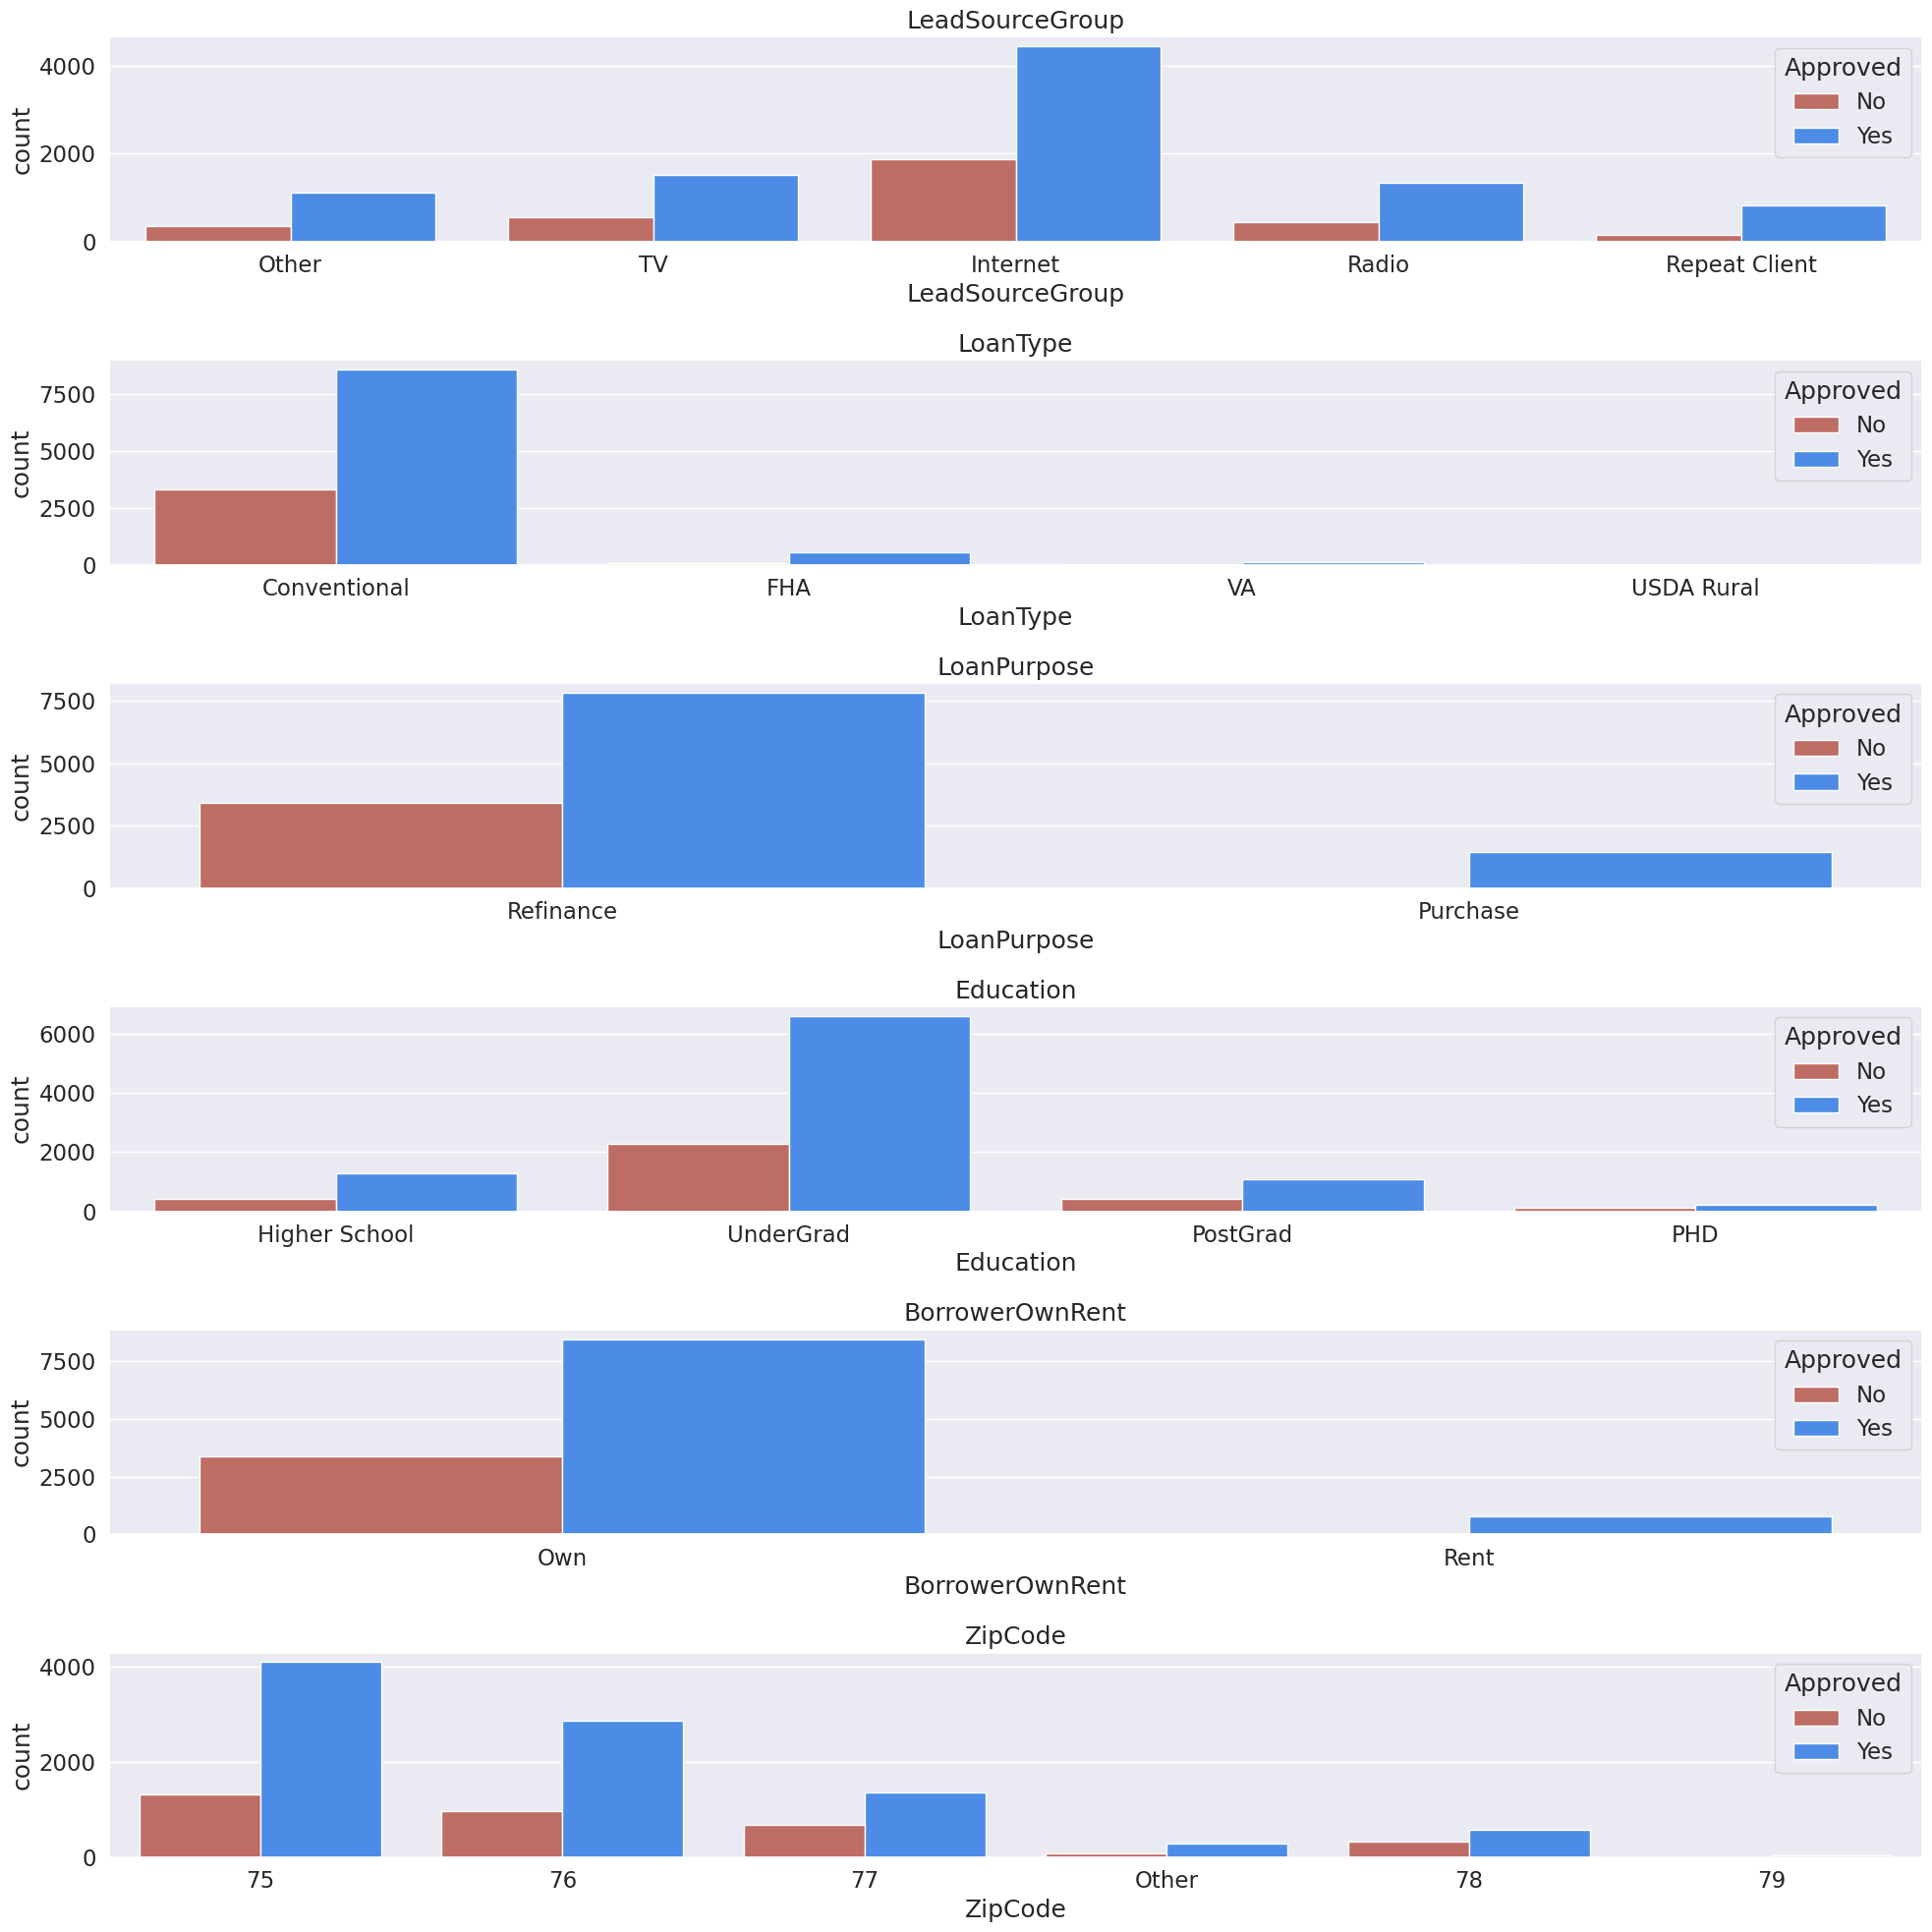

In [344]:
### Check distribution of all Categorical features
plt.figure(figsize=(20,20), facecolor='white')
# plot numbering starts at 1, not 0`
plot_number = 1
for  col in catVars[:-1]:
    # Inside of an image that's a 15x13 grid, put this
    # graph in the in the plot_number slot.
    ax = plt.subplot(len(catVars[:-1]), 1, plot_number)
    sns.countplot(x=col,data=loan_original,hue='Approved',palette=['#CD6155','#3388FF'])
    ax.set_title(col)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

### Inference :-
Loan Approval rate is high for leads coming through Internet , TV & Radio channel in comparision with other channels. Internet is contributing highest in it.
Loan Approval rate is high for Refinance-Cash-out & Refinance .
Loan Approval rate is high for conventional loan types.
Loan Approval rate is high for loan applicants ,who've their own home.
Loan Approval rate is high for loan applicants,who're are from ZipCode 75 & 76.

<Axes: xlabel='Approved'>

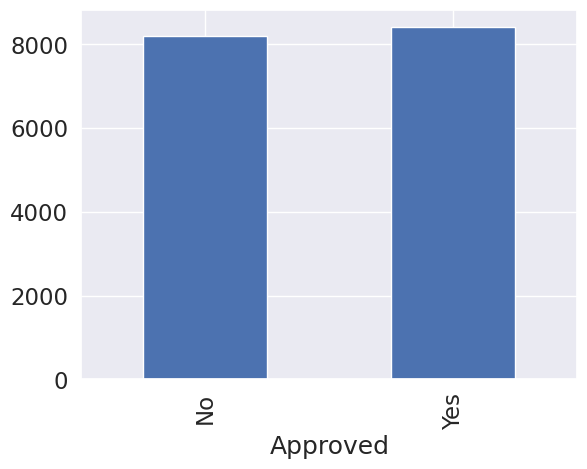

In [345]:
#Check loan Approval status based on total income
loan_original.groupby('Approved')['BorrowerTotalMonthlyIncome'].mean().plot.bar()



Difference in mean income based on Loan Approval status is quite marginal. Let's create bins for applicants's total income and analyze with respect to Loan Approval Status


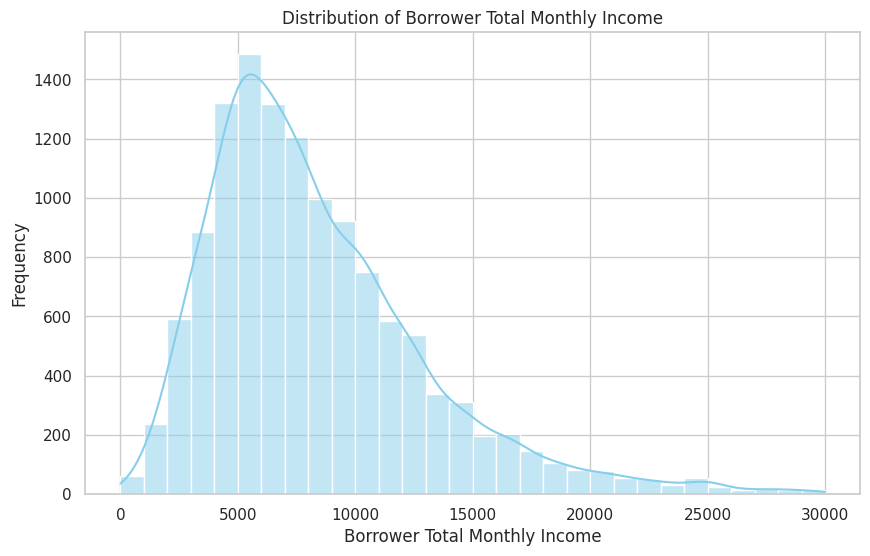

In [346]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, for additional styling

# Assuming 'loan_data' is your DataFrame and 'BorrowerTotalMonthlyIncome' is the income variable
# Replace 'loan_data' and 'BorrowerTotalMonthlyIncome' with the actual names in your dataset.

# Set the style (optional, for better visualization)
sns.set(style="whitegrid")

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(loan_original['BorrowerTotalMonthlyIncome'], bins=30, kde=True, color='skyblue')

# Add labels and title
plt.title('Distribution of Borrower Total Monthly Income')
plt.xlabel('Borrower Total Monthly Income')
plt.ylabel('Frequency')

# Show the plot
plt.show()


<Axes: xlabel='IncomeBin', ylabel='count'>

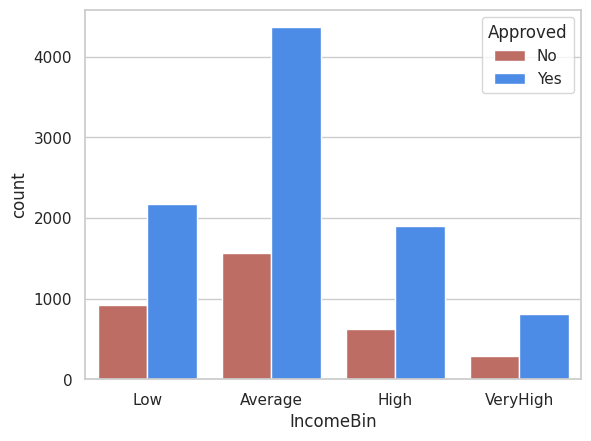

In [347]:
#Create bins
bins=[0,5000,10000,15000,loan_original.BorrowerTotalMonthlyIncome.max()]
group=['Low','Average','High','VeryHigh']
loan_original['IncomeBin']=pd.cut(loan_original['BorrowerTotalMonthlyIncome'],bins,labels=group)
sns.countplot(x='IncomeBin',data=loan_original,hue='Approved',palette=['#CD6155','#3388FF'])

We can clearly see that It supports out hypothesis that applicants with higher income would have higher chance of loan being approved


<Axes: xlabel='Approved'>

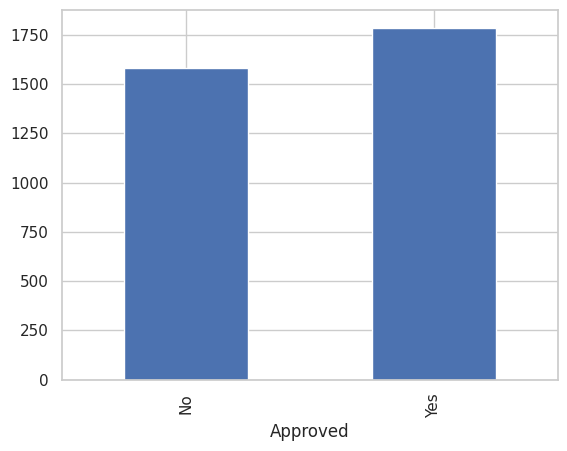

In [348]:
#We will analyze the co-applicant income
#Check loan Approval status based on total income
loan_original.groupby('Approved')['CoBorrowerTotalMonthlyIncome'].mean().plot.bar()

There's significant difference between mean income of coapplicants with respect to Loan Approval status. We've already seen that CoBorrowerTotalMonthlyIncome hass bimodal distribution


<Axes: xlabel='IncomeBin', ylabel='count'>

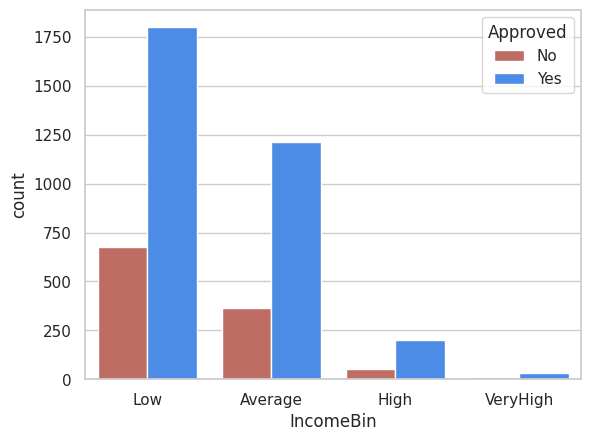

In [349]:
#Create bins
bins=[0,5000,10000,15000,loan_original.CoBorrowerTotalMonthlyIncome.max()]
group=['Low','Average','High','VeryHigh']
loan_original['IncomeBin']=pd.cut(loan_original['CoBorrowerTotalMonthlyIncome'],bins,labels=group)
sns.countplot(x='IncomeBin',data=loan_original,hue='Approved',palette=['#CD6155','#3388FF'])

We can clearly see that It supports out hypothesis that applicants with higher income would have higher chance of loan being approved. Let's combine both applicant's income and analyze


<Axes: xlabel='Approved'>

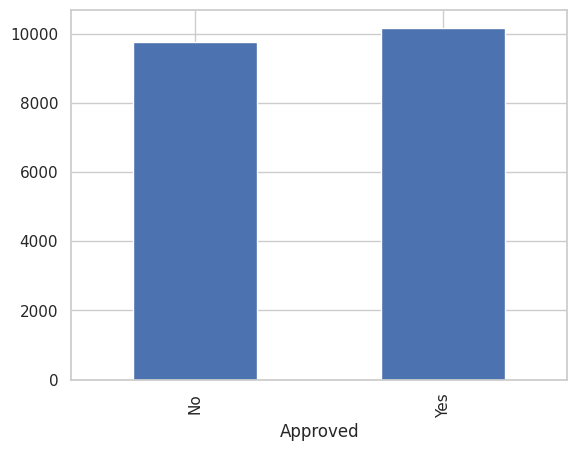

In [350]:
#Check loan Approval status based on total income
loan_original.groupby('Approved')['TotalIncome'].mean().plot.bar()

We can see that proportion of loans getting approved for applicants having low Total_Income is very less compared to that of applicants with Average, High & Very High Income.


<Axes: xlabel='Approved'>

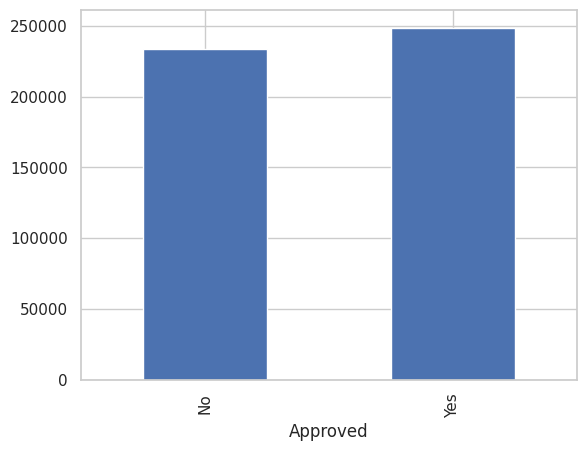

In [351]:
#Let’s visualize the Loan Amount variable.
loan_original.groupby('Approved')['TotalLoanAmount'].mean().plot.bar()



~ ( It can be seen that the proportion of approved loans is higher for Low and Average Loan Amount as compared to that of High Loan Amount which supports our hypothesis in which we considered that the chances of loan approval will be high when the loan amount is less.)
Let’s drop the bins which we created for the exploration part.
We will also convert the target variable’s categories into 0 and 1 so that we can find its correlation with numerical variables. One more reason to do so is few models like logistic regression takes only numeric values as input. We will replace N with 0 and Y with 1.


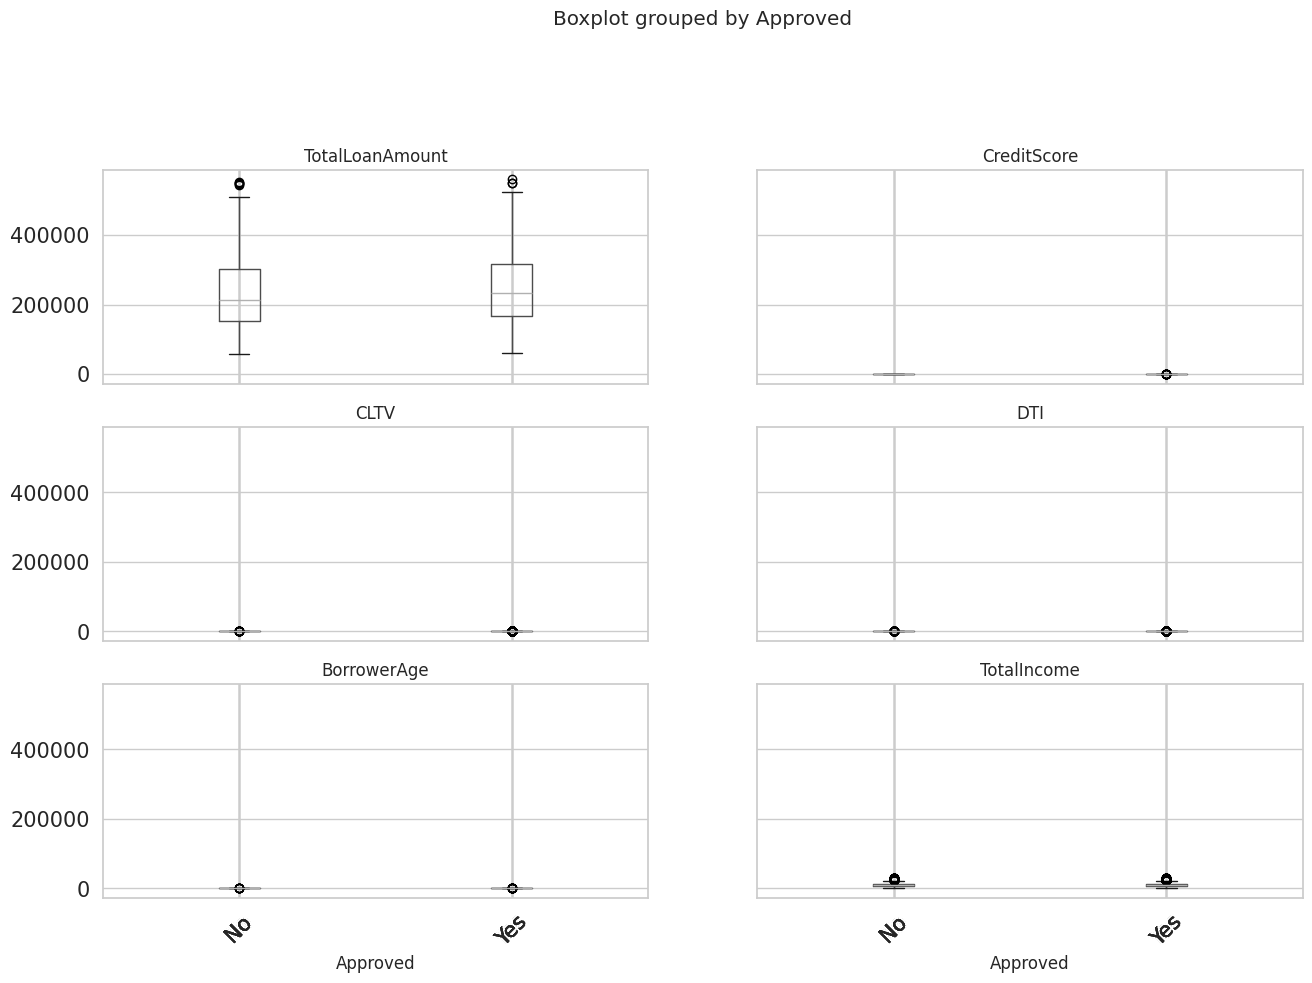

In [352]:
#Box plot by Target Variable
boxplot = loan_original.boxplot(column=numVars,by='Approved',figsize=(15,20) ,layout=(6, 2),grid=True, rot=45, fontsize=15)


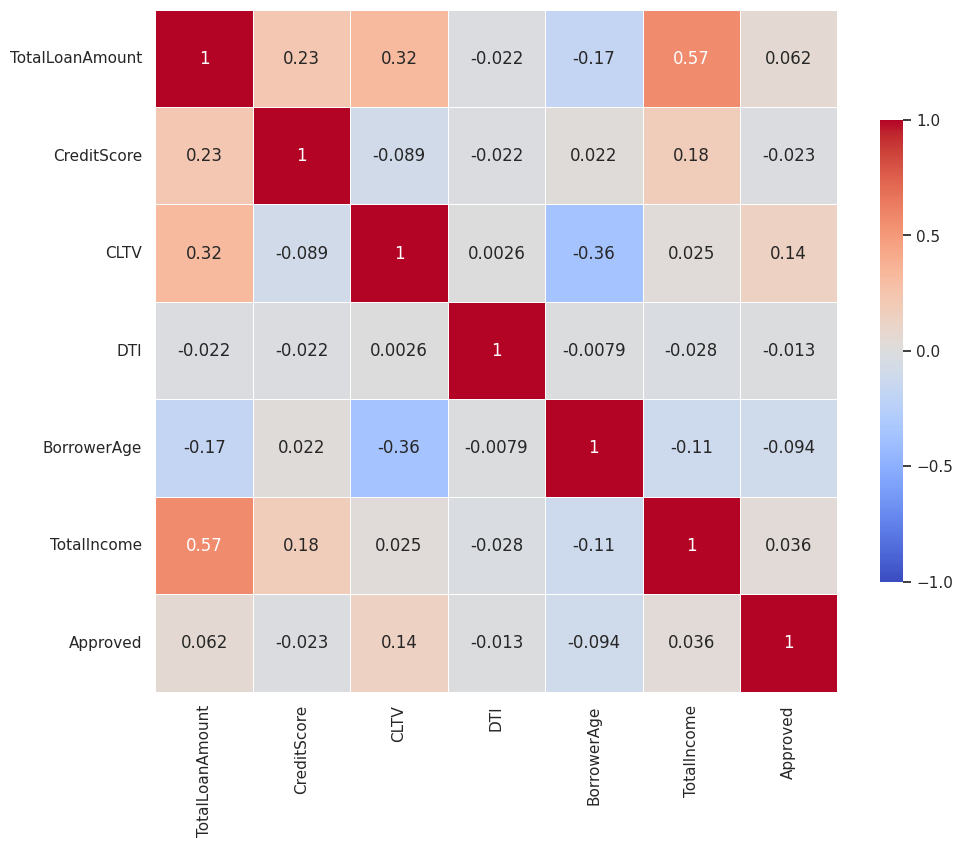

In [353]:
loan_original.Approved.replace({'Yes':1,'No':0},inplace=True)

# 5. Correlation Matrix

numVars+=['Approved']

#Correlation Plot
f, ax = plt.subplots(figsize=(11, 15))
# clms=['FLCount','Internet','Radio','TV','SocialMedia','Others']
corr_matrix = loan_original[numVars].corr()
heatmap = sns.heatmap(corr_matrix,
#                       mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

# Step 5: Split the data into train and test set
Note: Apply all your data preprocessing steps in train set first and keep test set aside.

In [354]:
data_bkp = loan_original.copy(deep=True)

In [355]:
########## Split Features and Target Varible ############

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming 'loan_original' is your DataFrame
# Replace 'loan_original' with the actual name of your DataFrame

# Split original data into train_df and test_df
train_df, test_df = train_test_split(loan_original, test_size=0.2, stratify=loan_original['Approved'], random_state=42)




# Step 6: Feature Engineering

## Step 6.1: Missing Value Imputation

In [356]:
loan_original.isna().sum()


,0
LeadID,0
DateAdded,0
LeadSourceGroup,0
LoanOfficer,4
Group,4
ZipCode,0
ApprovalDate,3620
LoanPurpose,0
LoanType,0
TotalLoanAmount,0


### Numerical values imputation tips :
Find the number of NaN entries in the age column and their row index. Calculate the mean, Standard deviation of the Age column and check the distribution of the age column.We can fill the missing values with randomly generated integer values between (mean+Standard deviation, mean-Standard deviation). Use : np.isnan; np.random.randint; concept of slicing dataframe. Convert the age column as an integer data type.



Mean of Age : 50.26332970620239
Std of Age : 11.992235551644455
Count of Nan in Age column : 0


<Axes: ylabel='Frequency'>

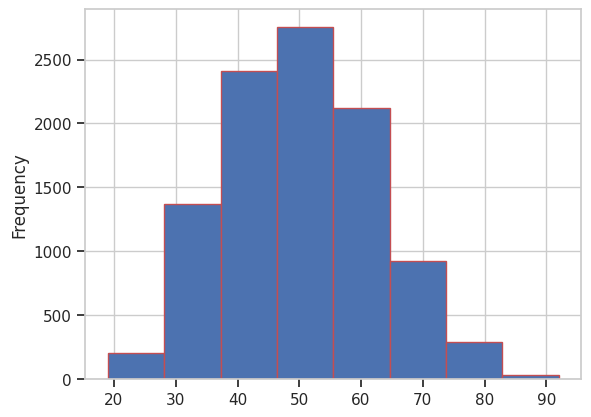

In [357]:
age_avg = train_df['BorrowerAge'].mean() # Average Age
print("Mean of Age :", age_avg)
age_std = train_df['BorrowerAge'].std() # Standard Deviation
print("Std of Age :",age_std)
age_null_count = train_df['BorrowerAge'].isnull().sum() # Number of null records in this feature
print("Count of Nan in Age column :",age_null_count)
## Plotting the histogram plot
train_df['BorrowerAge'].plot(kind='hist',bins=8,edgecolor='r')

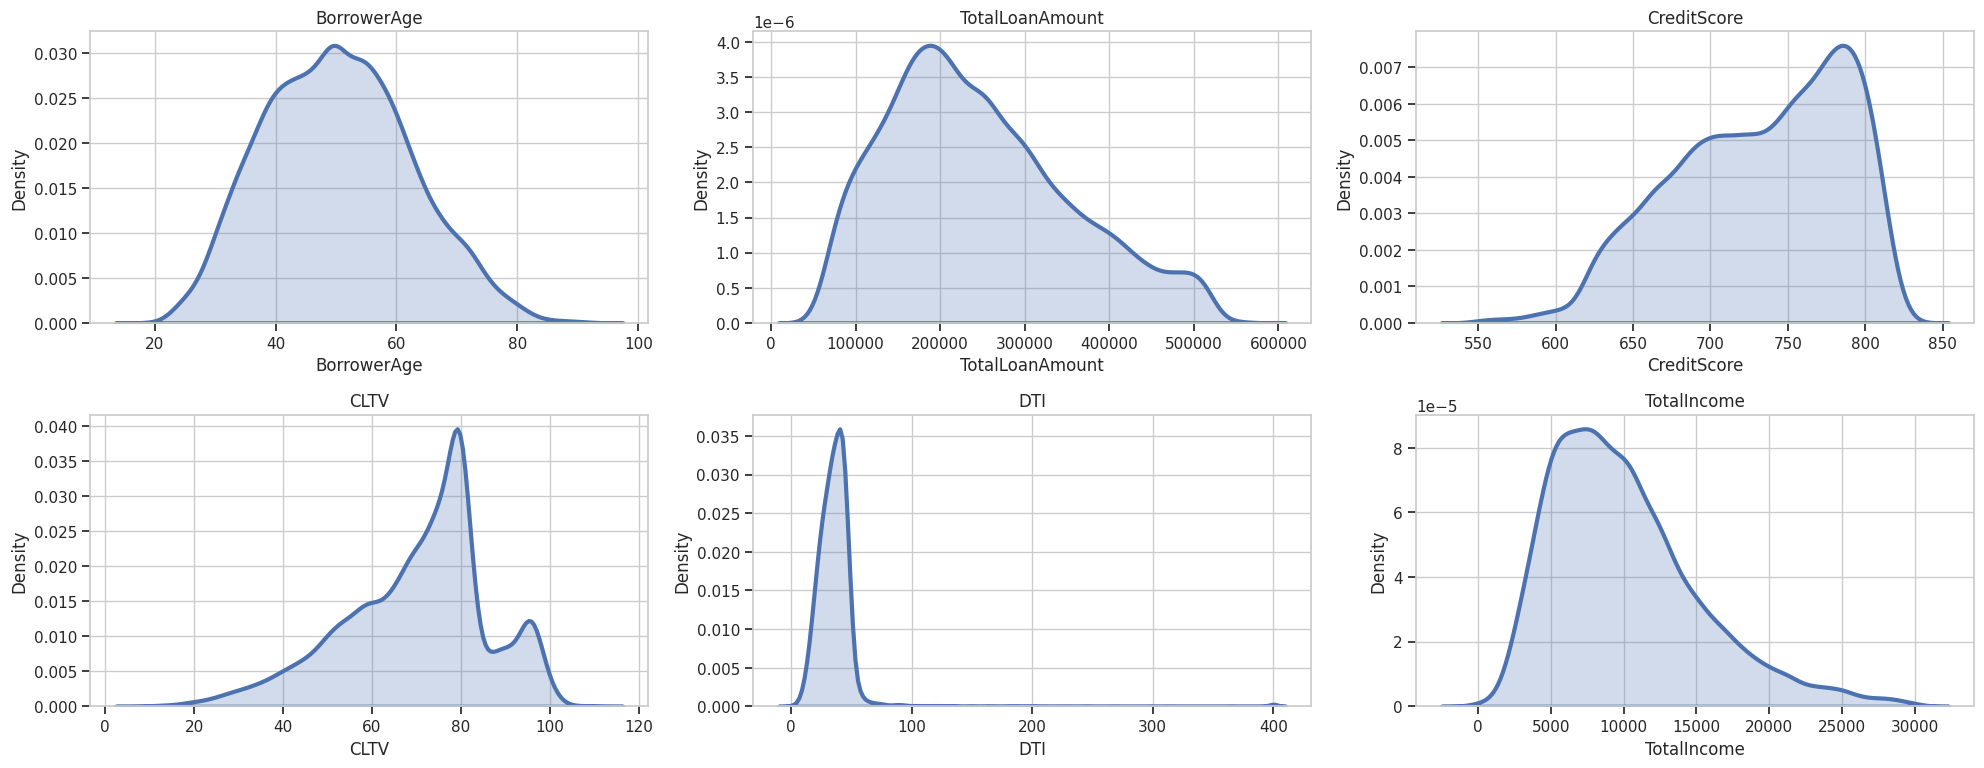

In [361]:
### Check distribution of all numerical features
numerical_vars = ['BorrowerAge', 'TotalLoanAmount', 'CreditScore', 'CLTV', 'DTI', 'TotalIncome']

plt.figure(figsize=(20,15), facecolor='white')
# plot numbering starts at 1, not 0
plot_number = 1
for  col in numerical_vars:
    # Inside of an image that's a 15x13 grid, put this
    # graph in the in the plot_number slot.
    ax = plt.subplot(4, 3, plot_number)
    sns.distplot(loan_original[col], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3})
    ax.set_title(col)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

In [362]:
import pandas as pd

num_cols = ['BorrowerAge','TotalLoanAmount','CreditScore','CLTV','DTI','BorrowerTotalMonthlyIncome', 'TotalIncome']

skew_kurt = loan_original[num_cols].agg(['skew','kurtosis']).T
print(skew_kurt)


                                 skew    kurtosis
BorrowerAge                  0.216239   -0.408728
TotalLoanAmount              0.558042   -0.374000
CreditScore                 -0.453894   -0.662970
CLTV                        -0.573055    0.144979
DTI                         11.072460  166.387738
BorrowerTotalMonthlyIncome   1.286842    2.175526
TotalIncome                  0.979017    0.923149


In [363]:
# Define a function, this takes dataframe as a parameter and returns the transformed
# Dataframe, filling the missing values of age feature as discussed above.

import numpy as np

# Define a function to impute missing values for all numerical variables
import numpy as np

def impute_numerical(df, numerical_vars, skew_thresh=0.5, kurt_thresh=10, random_state=42):
    np.random.seed(random_state)
    df = df.copy()

    for var in numerical_vars:
        skew = df[var].skew()
        kurt = df[var].kurtosis()

        if abs(skew) < skew_thresh and kurt < kurt_thresh:
            # Normal-like → sample from normal(mean, std)
            mean_val = df[var].mean()
            std_val  = df[var].std()
            null_count = df[var].isna().sum()
            fill_vals = np.random.normal(mean_val, std_val, size=null_count)
            df.loc[df[var].isna(), var] = fill_vals
        else:
            # Skewed/heavy tails → median
            median_val = df[var].median()
            df[var] = df[var].fillna(median_val)

    return df


# Assuming numerical_vars is a list of numerical variables
numerical_vars = ['BorrowerAge', 'TotalLoanAmount', 'CreditScore', 'CLTV', 'DTI', 'TotalIncome']

# Call the function to impute missing values for numerical variables
train_df = impute_numerical(train_df, numerical_vars)
test_df = impute_numerical(test_df, numerical_vars)

# Check the information after imputation
train_df[numerical_vars].isna().sum()


,0
BorrowerAge,0
TotalLoanAmount,0
CreditScore,0
CLTV,0
DTI,0
TotalIncome,0


In [364]:
# Check the information after imputation
test_df[numerical_vars].isna().sum()

,0
BorrowerAge,0
TotalLoanAmount,0
CreditScore,0
CLTV,0
DTI,0
TotalIncome,0


In [365]:
def impute_cat_missing_values(X, features_to_impute):
    for feature in features_to_impute:
        mode_value = X[feature].mode().values[0]
        X[feature].fillna(mode_value, inplace=True)

    return X

# Specify the features to impute
cat_vars = ['ZipCode', 'BorrowerOwnRent', 'BorrowerYearsInSchool', 'Education','LeadSourceGroup']

# Example usage:
# Assuming X_train is your training data and X_test is your test data
train_df = impute_cat_missing_values(train_df, cat_vars)
test_df = impute_cat_missing_values(test_df, cat_vars)


In [366]:
train_df[cat_vars].isna().sum()

,0
ZipCode,0
BorrowerOwnRent,0
BorrowerYearsInSchool,0
Education,0
LeadSourceGroup,0


In [367]:
test_df[cat_vars].isna().sum()

,0
ZipCode,0
BorrowerOwnRent,0
BorrowerYearsInSchool,0
Education,0
LeadSourceGroup,0


## Step 6.2: Outliers Treatment

In [368]:
#outliers check
import numpy as np
import pandas as pd

def identifyOutliers(df, clmn):
    Q1 = df[clmn].quantile(0.25)
    Q3 = df[clmn].quantile(0.75)
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    outliers = df[(df[clmn] < Lower_Whisker) | (df[clmn] > Upper_Whisker)]
    pct = round(len(outliers) / len(df) * 100, 2)

    print(f"{clmn} → Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}, "
          f"Lower={Lower_Whisker:.2f}, Upper={Upper_Whisker:.2f}, "
          f"% of outliers={pct}%")

    return Lower_Whisker, Upper_Whisker

import numpy as np
import pandas as pd

def treat_outliers(df):
    df = df.copy()

    # Business-rule caps (hard bounds)
    bounds = {
        'CLTV': (0, 100),
        'DTI': (0, 500),  # or 200 if you want stricter cap
        'BorrowerAge': (18, 100)  # typical age range
    }

    # Step 1: Apply hard business caps
    for col, (lo, hi) in bounds.items():
        if col in df.columns:
            df[col] = np.clip(df[col], lo, hi)

    # Step 2: Winsorize financial vars (cap at IQR whiskers)
    winsorize_cols = ['TotalLoanAmount', 'BorrowerTotalMonthlyIncome', 'TotalIncome', 'DTI', 'CLTV']
    for col in winsorize_cols:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            df[col] = np.where(df[col] < lower, lower,
                        np.where(df[col] > upper, upper, df[col]))

    # Step 3: Median replacement for invalid cases (e.g., 0 income with positive DTI)
    if 'BorrowerTotalMonthlyIncome' in df.columns and 'DTI' in df.columns:
        invalid_mask = (df['BorrowerTotalMonthlyIncome'] <= 0) & (df['DTI'] > 0)
        if invalid_mask.any():
            median_dti = df['DTI'].median()
            df.loc[invalid_mask, 'DTI'] = median_dti
            median_income = df['BorrowerTotalMonthlyIncome'][df['BorrowerTotalMonthlyIncome'] > 0].median()
            df.loc[invalid_mask, 'BorrowerTotalMonthlyIncome'] = median_income

    return df


for col in train_df[numVars[:-1]]:
    identifyOutliers(train_df,col)

TotalLoanAmount → Q1=163000.00, Q3=315000.00, IQR=152000.00, Lower=-65000.00, Upper=543000.00, % of outliers=0.07%
CreditScore → Q1=690.00, Q3=778.00, IQR=88.00, Lower=558.00, Upper=910.00, % of outliers=0.08%
CLTV → Q1=59.80, Q3=80.00, IQR=20.20, Lower=29.50, Upper=110.30, % of outliers=1.61%
DTI → Q1=28.00, Q3=43.00, IQR=15.00, Lower=5.50, Upper=65.50, % of outliers=1.59%
BorrowerAge → Q1=41.00, Q3=58.00, IQR=17.00, Lower=15.50, Upper=83.50, % of outliers=0.21%
TotalIncome → Q1=6197.54, Q3=12750.00, IQR=6552.46, Lower=-3631.15, Upper=22578.69, % of outliers=3.0%


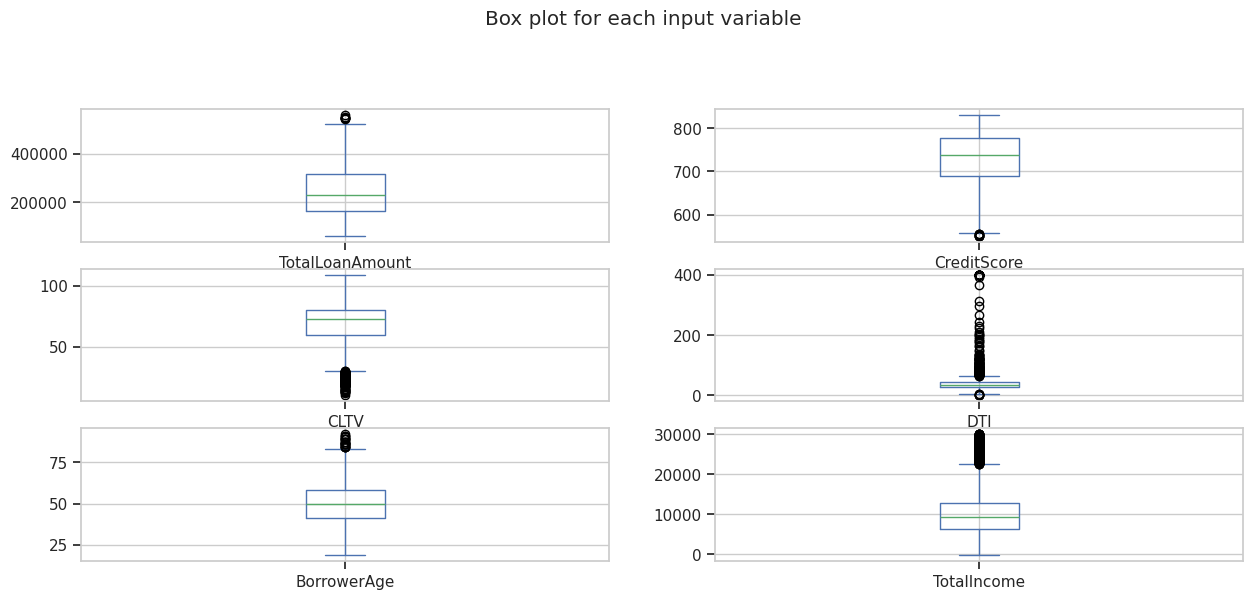

In [373]:
# Outliers check
train_df[numVars].plot(kind='box',subplots=True,layout=(5,2),sharex=False,sharey=False,figsize=(15,10),
       title='Box plot for each input variable')
plt.savefig('BoxPlots')
plt.show()

In [ ]:
for col in train_df[numVars[:-1]]:
    identifyOutliers(train_df,col)


In [ ]:
# Outliers check
train_df.plot(kind='box',subplots=True,layout=(4,3),sharex=False,sharey=False,figsize=(15,15),
       title='Box plot for each input variable')
plt.savefig('BoxPlots')
plt.show()


In [ ]:
for col in test_df[numVars[:-1]]:
    identifyOutliers(test_df,col)

## Step 6.3: Chi-Square test for categorical variables

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming 'loan_data' is your DataFrame
# Replace 'loan_data' with the actual name of your DataFrame

# Categorical variables
categorical_vars = ['LeadSourceGroup', 'ZipCode', 'Education', 'LoanPurpose', 'LoanType', 'BorrowerOwnRent', 'IsCoBorrowerower', 'Approved']

# Perform Chi-square tests for each pair of categorical variables
for var1 in categorical_vars:
    for var2 in categorical_vars:
        if var1 != var2:  # Exclude comparisons with the same variable
            contingency_table = pd.crosstab(train_df[var1], train_df[var2])

            # Perform Chi-square test
            chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

            # Print results
            print(f"Chi-square test between {var1} and {var2}:")
            print(f"Chi2 Statistic: {chi2_stat}")
            print(f"P-Value: {p_value}")
            print("")

# Note: This code assumes 'loan_data' is your DataFrame. Replace 'loan_data' with the actual name in your dataset.


### Chi-Square result:

The Chi-square test results indicate the association between different categorical variables in your loan approval classification use case. Let's analyze the insights and arrange the variables in order of their importance based on the Chi-square test results:

1. **LoanPurpose:**
   - Chi2 Statistic: 475.92
   - P-Value: 1.65e-105
   - **Insight:** The purpose for which the loan is sought (LoanPurpose) has the highest importance and a highly significant association with loan approval. It is a critical factor in predicting loan approval decisions.

2. **BorrowerOwnRent:**
   - Chi2 Statistic: 229.78
   - P-Value: 6.65e-52
   - **Insight:** Whether the borrower owns or rents their residence (BorrowerOwnRent) is the second most important variable, showing a strong association with loan approval.

3. **ZipCode:**
   - Chi2 Statistic: 113.26
   - P-Value: 8.37e-23
   - **Insight:** The geographical location, represented by the Zip Code, is the third most important variable, indicating a significant association with loan approval.

4. **LeadSourceGroup:**
   - Chi2 Statistic: 73.15
   - P-Value: 4.91e-15
   - **Insight:** The source of the loan application (LeadSourceGroup) is moderately important, with a significant association with loan approval.

5. **LoanType:**
   - Chi2 Statistic: 46.91
   - P-Value: 3.64e-10
   - **Insight:** The type of loan is another significant variable, although it is less important than LoanPurpose, BorrowerOwnRent, ZipCode, and LeadSourceGroup.

6. **Education:**
   - Chi2 Statistic: 11.03
   - P-Value: 0.0116
   - **Insight:** Education level has a statistically significant but relatively smaller impact on loan approval compared to other variables.

7. **IsCoBorrower:**
   - Chi2 Statistic: 0.0
   - P-Value: 1.0
   - **Insight:** The variable "IsCoBorrower" does not show a significant association with any other variable in the provided results.

**Final Verdict:**
- Focus on LoanPurpose, BorrowerOwnRent, ZipCode, LeadSourceGroup, and LoanType as they have demonstrated significant associations with loan approval.
- Consider the order of importance when making decisions or building models: LoanPurpose is the most crucial, followed by BorrowerOwnRent, ZipCode, LeadSourceGroup, LoanType, Education, and IsCoBorrower.

It's important to note that these insights are based on statistical associations, and the practical significance of these variables should also be considered in the context of your specific loan approval model or decision-making process.

In [ ]:
train_df.isna().sum()

## Step 6.4: ANOVA test for numerical variables

In [ ]:
import pandas as pd
from scipy.stats import f_oneway

# Assuming 'loan_data' is your DataFrame
# Replace 'loan_data' with the actual name of your DataFrame

# Categorical variables
categorical_vars = ['LeadSourceGroup', 'LoanOfficer', 'Group', 'LoanPurpose', 'LoanType', 'BorrowerOwnRent', 'BorrowerCity', 'BorrowerState', 'Approved']

# Numerical variables
numerical_vars = ['TotalLoanAmount', 'CreditScore', 'CLTV', 'DTI', 'BorrowerAge', 'BorrowerYearsInSchool', 'BorrowerTotalMonthlyIncome', 'CoBorrowerYearsInSchool', 'CoBorrowerAge', 'CoBorrowerTotalMonthlyIncome']

# Perform ANOVA for each numerical variable with 'Approved' as the grouping variable
for num_var in numerical_vars:
    groups = []
    for category in train_df['Approved'].unique():
        groups.append(train_df[train_df['Approved'] == category][num_var])

    # Perform ANOVA
    f_statistic, p_value = f_oneway(*groups)

    # Print results
    print(f"ANOVA for {num_var} and Approved:")
    print(f"F-Statistic: {f_statistic}")
    print(f"P-Value: {p_value}")
    print("")

# Note: This code assumes 'loan_data' is your DataFrame and 'Approved' is the target variable.
# Replace 'loan_data' and 'Approved' with the actual names in your dataset.


### ANOVA Test result:

The ANOVA test results provide insights into the association between numerical variables and loan approval in your classification use case. Let's analyze the results and arrange the variables in order of their importance based on the F-statistic and p-value:

Certainly! Based on the ANOVA test results for numerical variables in your loan approval classification use case, here are the insights and a final arrangement of variables in order of their importance:

1. **CLTV (Combined Loan-to-Value):**
   - F-Statistic: 166.89
   - P-Value: 6.90e-38
   - **Insight:** CLTV has the highest importance, with a highly significant association with loan approval. It is a critical factor in predicting loan approval decisions.

Note: $$ \text{CLTV} = \frac{\text{Sum of All Loan Amounts}}{\text{Appraised Property Value}} \times 100 $$
2. **BorrowerYearsInSchool:**
   - F-Statistic: 112.45
   - P-Value: 3.85e-26
   - **Insight:** The number of years the borrower spent in school is the second most important variable, showing a strong association with loan approval.

3. **BorrowerAge:**
   - F-Statistic: 84.76
   - P-Value: 4.01e-20
   - **Insight:** Borrower's age is the third most important variable, indicating a significant association with loan approval.

4. **TotalLoanAmount:**
   - F-Statistic: 39.47
   - P-Value: 3.47e-10
   - **Insight:** The total loan amount is a significant variable, although it is less important than CLTV, BorrowerYearsInSchool, and BorrowerAge.

5. **CoBorrowerTotalMonthlyIncome:**
   - F-Statistic: 15.13
   - P-Value: 0.00010
   - **Insight:** The total monthly income of the co-borrower is another significant variable, indicating a moderate association with loan approval.

6. **DTI (Debt-to-Income Ratio):**
   - F-Statistic: 10.28
   - P-Value: 0.00135
   - **Insight:** Debt-to-Income Ratio is a moderately important variable, showing a significant association with loan approval.
Note:
The formula for Debt-to-Income (DTI) ratio is:

$$\ \text{DTI} = \frac{\text{Total Monthly Debt Payments}}{\text{Gross Monthly Income}} \times 100 \$$

7. **CreditScore:**
   - F-Statistic: 5.92
   - P-Value: 0.01496
   -

**Insight:** Credit score is a significant variable, although it has a comparatively smaller impact on loan approval compared to other variables.

8. **CoBorrowerYearsInSchool:**
   - F-Statistic: 29.82
   - P-Value: 4.85e-08
   - **Insight:** The number of years the co-borrower spent in school is another moderately important variable, indicating a significant association with loan approval.

9. **CoBorrowerAge:**
   - F-Statistic: 5.06
   - P-Value: 0.02457
   - **Insight:** Co-borrower's age is a variable with a smaller impact on loan approval compared to other factors.

10. **BorrowerTotalMonthlyIncome:**
    - F-Statistic: 6.60
    - P-Value: 0.01019
    - **Insight:** Borrower's total monthly income is the least important among the numerical variables considered, but it still shows a significant association with loan approval.

**Final Verdict:**
- Focus on CLTV, BorrowerYearsInSchool, and BorrowerAge as they have demonstrated the highest importance and highly significant associations with loan approval.
- Consider TotalLoanAmount, CoBorrowerTotalMonthlyIncome, and DTI as they are also significant variables in predicting loan approval.
- CreditScore, CoBorrowerYearsInSchool, CoBorrowerAge, and BorrowerTotalMonthlyIncome have smaller impacts on loan approval but are still statistically significant.

These insights are based on the statistical associations observed in the ANOVA test, and practical considerations should also be taken into account when making decisions in your loan approval model or decision-making process.

## Step 6.5: Drop irrelevant variables

In [ ]:
#Drop below features
#Drop irrelevant fetures
unused_vars = ['LeadID','DateAdded','LoanOfficer','Group','IsCoBorrowerower','BorrowerTotalMonthlyIncome',
                    'CoBorrowerTotalMonthlyIncome','BorrowerYearsInSchool','CoBorrowerYearsInSchool','CoBorrowerAge','BorrowerCity',
                    'BorrowerState','Group','IncomeBin','ApprovalDate']
train_df.drop(unused_vars, axis=1, inplace=True)

test_df.drop(unused_vars, axis=1, inplace=True)


## Step 6.6: Split train and test data into X, and Y variables training and testing respectively.

In [ ]:
# Split train_df into features (X_train) and target variable (y_train)
X_train = train_df.drop(columns='Approved')
y_train = train_df['Approved']

# Split test_df into features (X_test) and target variable (y_test)
X_test = test_df.drop(columns='Approved')
y_test = test_df['Approved']

# Optionally, convert to DataFrames if needed
X_train = pd.DataFrame(data=X_train, columns=X_train.columns)
X_test = pd.DataFrame(data=X_test, columns=X_test.columns)
y_train = pd.DataFrame(data=y_train, columns=['Approved'])
y_test = pd.DataFrame(data=y_test, columns=['Approved'])

In [ ]:
# # Apply SMOTE to the training data
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
catVars.remove('LoanOfficer')
catVars

## Step 6.7: Encode categorical variables

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def encode(df, catVars):
    if len(catVars) == 0:
        return df, None

    # One-Hot Encoding
    encoder = OneHotEncoder(drop='first', sparse=False)
    OHE = encoder.fit(df[catVars])
    cat_feature_names = OHE.get_feature_names_out(catVars)

    # Prefix encoded values with column names
    OHEdf = pd.DataFrame(OHE.transform(df[catVars]), columns=cat_feature_names)

    NumDf = df.drop(catVars, axis=1).reset_index(drop=True)

    df_ = pd.concat([OHEdf, NumDf], axis=1)

    return df_, OHE

# Assuming loan_original is your DataFrame
X_train, OHE = encode(X_train, catVars)
X_test, OHE = encode(X_test, catVars)



In [ ]:
X_train.columns

In [ ]:
X_train.head()

In [ ]:
X_train.isna().sum()

In [ ]:
import pickle

pickle.dump(OHE, open('./encoder.pkl' ,'wb'))
enc = pickle.load(open('./encoder.pkl','rb'))



## Step 6.8: Apply Standard Scalar

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[0,:]

In [ ]:
X_test_scaled[0,:]

#Step 7 : Model Building




## Step 7.1: GridSearch for hyper parameters tuning


In [ ]:
from sklearn.metrics import confusion_matrix ,classification_report
from sklearn.model_selection import cross_val_score
import scikitplot as skplt

# Write a function for Grid Search
def GridSearch(model,param_grid,cv,X,y,scoring=None):
    # Random search of parameters
    gcv = GridSearchCV(estimator = model, param_grid=param_grid , refit = True, cv = cv, verbose=1,  n_jobs = -1)
    # Fit the model
    gcv.fit(X,y)

    return gcv.best_params_

def modelPerformance(model,X,y,dataType):
    print("=== Model Performance report on ",dataType," Data ===")
    y_pred = model.predict(X)
    print("=== Confusion Matrix ===")
    print(confusion_matrix(y, y_pred))
    print('\n')
    print("=== Classification Report ===")
    print(classification_report(y, y_pred))
    skplt.metrics.plot_confusion_matrix(y,y_pred, normalize=True, figsize=(8,3))


In [ ]:
X_train_bkp, X_test_bkp = X_train.copy(deep=True), X_test.copy(deep=True)
X_train, X_test = X_train_scaled.copy(), X_test_scaled.copy()

In [ ]:
# random forest model creation

#Model performance on CV Training Data
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix ,classification_report
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

from sklearn.ensemble import RandomForestClassifier

param_grid = {
              'max_depth': [2, 3,4 ,5],
              'min_samples_leaf': [1,3, 5, 10,],
              'min_samples_split':[2,3,4],
              'max_features':['auto','sqrt'],
              'n_estimators':[100,200,300,400]
              }


# random forest model creation
rfc_org = RandomForestClassifier(random_state=123, n_jobs=-1)

best_params=GridSearch(rfc_org,param_grid,3,X_train,y_train)





In [ ]:
rfc_org = RandomForestClassifier(
                             max_depth=best_params['max_depth'],
                             max_features=best_params['max_features'],
                             min_samples_split=best_params['min_samples_split'],
                             min_samples_leaf=best_params['min_samples_leaf'],
                             n_estimators=best_params['n_estimators'],
                             n_jobs=-1

                            )
rfc_org.fit(X_train,y_train)

In [ ]:
#Model performance on Training Data
modelPerformance(rfc_org,X_train,y_train,'Train')



In [ ]:

#Model performance on Test Data
modelPerformance(rfc_org,X_test,y_test,'Test')





In [ ]:
###################### SMOTE Sampling ##################################

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

oversampled = SMOTE(random_state=0)
X_train_SMOTE, y_train_SMOTE = oversampled.fit_resample(X_train, y_train)
y_train_SMOTE.value_counts()


In [ ]:
# random forest model creation
rfc_SMOTE = RandomForestClassifier(random_state=123, n_jobs=-1)
best_params=GridSearch(rfc_SMOTE,param_grid,3,X_train_SMOTE,y_train_SMOTE)


In [ ]:
rfc_SMOTE = RandomForestClassifier(
                             max_depth=best_params['max_depth'],
                             max_features=best_params['max_features'],
                             min_samples_split=best_params['min_samples_split'],
                             min_samples_leaf=best_params['min_samples_leaf'],
                             n_estimators=best_params['n_estimators'],
                             n_jobs=-1

                            )
rfc_SMOTE.fit(X_train_SMOTE,y_train_SMOTE)

In [ ]:
############################ Class_weights ############################

In [ ]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

In [ ]:
#Fitting grid search to the train data with 5 folds
import plotly.express as px
from sklearn.model_selection import StratifiedKFold

# random forest model creation
rfc_class_wghts = RandomForestClassifier(random_state=123, n_jobs=-1)

gridsearch = GridSearchCV(estimator= rfc_class_wghts,
                          param_grid= param_grid,
                          cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=42),
                          n_jobs=-1,
                          scoring='f1',
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
# Create a DataFrame for plotting
weigh_data = pd.DataFrame({'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1 - weights)})

# Create an interactive line plot
fig = px.line(weigh_data, x='weight', y='score',
              labels={'weight': 'Weight for class 1', 'score': 'F1 score'},
              title='Scoring for different class weights',
              width=800, height=500)



In [ ]:
# Display the interactive plot
fig.show()

In [ ]:
rfc_class_wghts = RandomForestClassifier(
                             max_depth=best_params['max_depth'],
                             max_features=best_params['max_features'],
                             min_samples_split=best_params['min_samples_split'],
                             min_samples_leaf=best_params['min_samples_leaf'],
                             n_estimators=best_params['n_estimators'],
                             class_weight={0: 0.75, 1: 0.25},
                             n_jobs=-1

                            )
rfc_class_wghts.fit(X_train,y_train)

In [ ]:
# Assuming y_train is a DataFrame with "Approved" column
y_train_array = y_train["Approved"].values.astype(int)

In [ ]:
############################## Vanila XgBoost Classifier ##############################

from xgboost import XGBClassifier

param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_child_weight': [1, 3, 5, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# XGBoost model creation
xgb_org = XGBClassifier(random_state=123, n_jobs=-1)

best_params = GridSearch(xgb_org, param_grid, 3, X_train, y_train_array)

from xgboost import XGBClassifier

# Create XGBoost model with the best hyperparameters and class weights
xgb_org = XGBClassifier(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    n_jobs=-1
)

# Train the XGBoost model
xgb_org.fit(X_train, y_train_array)


In [ ]:
###################### SMOTE Sampling ##################################

# Assuming y_train is a DataFrame with "Approved" column
y_train_SMOTE = y_train_SMOTE["Approved"].values.astype(int)


In [ ]:

############################## XgBoost Classifier with SMOTE sampled data ##############################

from xgboost import XGBClassifier

param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_child_weight': [1, 3, 5, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# XGBoost model creation
xgb_SMOTE = XGBClassifier(random_state=123, n_jobs=-1)

best_params = GridSearch(xgb_SMOTE, param_grid, 3, X_train_SMOTE, y_train_SMOTE)

from xgboost import XGBClassifier

# Create XGBoost model with the best hyperparameters and class weights
xgb_SMOTE = XGBClassifier(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    n_jobs=-1
)

# Train the XGBoost model
xgb_SMOTE.fit(X_train_SMOTE, y_train_array)


In [ ]:
# Assuming y_train is a DataFrame with "Approved" column
y_train_array = y_train["Approved"].values.astype(int)

In [ ]:
# ############################## XgBoost Classifier with class weights ##############################
# import plotly.express as px
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# import pandas as pd


# # Assuming y_train is a DataFrame with "Approved" column
# # y_train_array = y_train["Approved"].astype('category').cat.codes

# # XGBoost model creation
# xgb_class_wghts = XGBClassifier(random_state=123, n_jobs=-1, objective='binary:logistic', eval_metric='logloss')



# # Fitting grid search to the train data with 5 folds
# gridsearch = GridSearchCV(estimator=xgb_class_wghts,
#                           param_grid=param_grid,
#                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#                           n_jobs=-1,
#                           scoring='f1',
#                           verbose=2).fit(X_train, y_train_array)

# # Create a DataFrame for plotting
# weigh_data = pd.DataFrame({'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1 - weights)})

# # Create an interactive line plot
# fig = px.line(weigh_data, x='weight', y='score',
#               labels={'weight': 'Weight for class 1', 'score': 'F1 score'},
#               title='Scoring for different class weights',
#               width=800, height=500)

# # Display the interactive plot
# fig.show()


In [ ]:
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_child_weight': [1, 3, 5, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# XGBoost model creation
xgb_class_wghts = XGBClassifier(n_jobs=-1, scale_pos_weight=0.22 / 0.78, random_state=123)

best_params = GridSearch(xgb_class_wghts, param_grid, 3, X_train, y_train_array)

from xgboost import XGBClassifier

# Create XGBoost model with the best hyperparameters and class weights
xgb_class_wghts = XGBClassifier(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    scale_pos_weight=0.22 / 0.78,  # Set scale_pos_weight based on the class weights
    n_jobs=-1
    )

# Train the XGBoost model
xgb_class_wghts.fit(X_train, y_train_array)


In [ ]:

y_train_array.dtype

In [ ]:
type(y_train_array)

In [ ]:
y_train_array

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE  # Import SMOTE if not already imported
from sklearn.utils.class_weight import compute_class_weight


# Model 1: Original RandomForestClassifier
y_pred_org = rfc_org.predict(X_test)

# Model 2: RandomForestClassifier with SMOTE
y_pred_smote = rfc_SMOTE.predict(X_test)

# Model 3: RandomForestClassifier with class weights
y_pred_class_wghts = rfc_class_wghts.predict(X_test)

# Model 4: XgBoost Classifier with class weights
y_pred_xgb_org = xgb_org.predict(X_test)

# Model 5: RandomForestClassifier with class weights
y_pred_xgb_SMOTE = xgb_SMOTE.predict(X_test)

# Model 6: XgBoost Classifier with class weights
y_pred_xgb_class_wghts = xgb_class_wghts.predict(X_test)

# Compare metrics for each model
models = ['rfc_org', 'rfc_SMOTE', 'rfc_class_wghts', 'xgb_org', 'xgb_SMOTE', 'xgb_class_wghts']


for model_name, y_pred in zip(models, [y_pred_org, y_pred_smote, y_pred_class_wghts, y_pred_xgb_org, y_pred_xgb_SMOTE, y_pred_xgb_class_wghts]):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Additional metrics
    classification_rep = classification_report(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    print(f"\nClassification Report for {model_name}:\n{classification_rep}")
    print(f"Confusion Matrix for {model_name}:\n{confusion_mat}")
    print("\n" + "="*40 + "\n")


In [ ]:
###################### Model Performances on Train Data ######################

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Model predictions on train data
y_pred_org_train = rfc_org.predict(X_train)
y_pred_smote_train = rfc_SMOTE.predict(X_train)
y_pred_class_wghts_train = rfc_class_wghts.predict(X_train)
y_pred_xgb_org_train = xgb_org.predict(X_train)
y_pred_xgb_SMOTE_train = xgb_SMOTE.predict(X_train)
y_pred_xgb_class_wghts_train = xgb_class_wghts.predict(X_train)

# Compare metrics for each model on train data
models = ['rfc_org', 'rfc_SMOTE', 'rfc_class_wghts', 'xgb_org', 'xgb_SMOTE', 'xgb_class_wghts']

# Initialize empty lists to store metrics
accuracy_list_train = []
precision_list_0_train, precision_list_1_train = [], []
recall_list_0_train, recall_list_1_train = [], []
f1_list_0_train, f1_list_1_train = [], []

for model_name, y_pred_train in zip(models, [y_pred_org_train, y_pred_smote_train, y_pred_class_wghts_train, y_pred_xgb_org_train, y_pred_xgb_SMOTE_train, y_pred_xgb_class_wghts_train]):
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_pred_train, average=None)

    # Append metrics to lists
    accuracy_list_train.append(accuracy_train)
    precision_list_0_train.append(precision_train[0])
    precision_list_1_train.append(precision_train[1])
    recall_list_0_train.append(recall_train[0])
    recall_list_1_train.append(recall_train[1])
    f1_list_0_train.append(f1_train[0])
    f1_list_1_train.append(f1_train[1])

    # Print metrics
    print(f"{model_name} Metrics on Train Data:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print(f"Precision (Class 0): {precision_train[0]:.4f}")
    print(f"Precision (Class 1): {precision_train[1]:.4f}")
    print(f"Recall (Class 0): {recall_train[0]:.4f}")
    print(f"Recall (Class 1): {recall_train[1]:.4f}")
    print(f"F1-score (Class 0): {f1_train[0]:.4f}")
    print(f"F1-score (Class 1): {f1_train[1]:.4f}")
    print("\n" + "="*40 + "\n")


# Plotting
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

metrics_list = [accuracy_list_train, precision_list_0_train, precision_list_1_train, recall_list_0_train, recall_list_1_train, f1_list_0_train, f1_list_1_train]
metric_labels = ['Accuracy', 'Precision (Class 0)', 'Precision (Class 1)', 'Recall (Class 0)', 'Recall (Class 1)', 'F1-score (Class 0)', 'F1-score (Class 1)']

# Plot each metric on separate subplots
for i, (metric_values, metric_label) in enumerate(zip(metrics_list, metric_labels)):
    row, col = divmod(i, 4)
    axes[row, col].bar(models, metric_values, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[row, col].set_ylabel(metric_label, fontsize=12)  # Adjust font size here
    axes[row, col].set_title(f'{metric_label} Comparison', fontsize=14)  # Adjust font size here
    axes[row, col].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

Let's analyze the results for the loan approval classification task based on the provided metrics for each model:

1. **rfc_org (Random Forest Classifier without any modifications):**
   - **Accuracy:** 74.07%
   - **Precision (Class 0):** 88.54%
   - **Precision (Class 1):** 73.85%
   - **Recall (Class 0):** 4.90%
   - **Recall (Class 1):** 99.76%
   - **F1-score (Class 0):** 9.29%
   - **F1-score (Class 1):** 84.88%

2. **rfc_SMOTE (Random Forest Classifier with SMOTE):**
   - **Accuracy:** 69.10%
   - **Precision (Class 0):** 41.81%
   - **Precision (Class 1):** 77.40%
   - **Recall (Class 0):** 36.00%
   - **Recall (Class 1):** 81.39%
   - **F1-score (Class 0):** 38.69%
   - **F1-score (Class 1):** 79.34%

3. **rfc_class_wghts (Random Forest Classifier with class weights):**
   - **Accuracy:** 74.70%
   - **Precision (Class 0):** 64.23%
   - **Precision (Class 1):** 75.40%
   - **Recall (Class 0):** 14.88%
   - **Recall (Class 1):** 96.92%
   - **F1-score (Class 0):** 24.16%
   - **F1-score (Class 1):** 84.82%

**Analysis:**
- **Accuracy:** rfc_class_wghts has the highest accuracy (74.70%), followed by rfc_org (74.07%), and then rfc_SMOTE (69.10%).
- **Precision:** rfc_org has the highest precision for both classes. However, rfc_class_wghts has a reasonable precision while considering both classes.
- **Recall:** rfc_org has very low recall for Class 0, while rfc_class_wghts has improved recall for both classes. rfc_SMOTE has a balanced recall for both classes but is lower compared to rfc_class_wghts.
- **F1-score:** rfc_org has the highest F1-score for Class 1, while rfc_class_wghts has a better balance between precision and recall for both classes.

**Conclusion:**
- Overall, considering the trade-off between precision, recall, and F1-score, the model **rfc_class_wghts** seems to be performing better on the training data for the loan approval classification task. It has a good balance between precision and recall for both classes, resulting in a higher F1-score. The choice of the best model also depends on the specific goals and requirements of your application. If balancing precision and recall is crucial, rfc_class_wghts might be a better choice despite having a lower accuracy compared to rfc_org.

In [ ]:
###################### Model Performances on Test Data ######################

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Model predictions
y_pred_org = rfc_org.predict(X_test)
y_pred_smote = rfc_SMOTE.predict(X_test)
y_pred_class_wghts = rfc_class_wghts.predict(X_test)
y_pred_xgb_org = xgb_org.predict(X_test)
y_pred_xgb_SMOTE = xgb_SMOTE.predict(X_test)
y_pred_xgb_class_wghts = xgb_class_wghts.predict(X_test)

# Compare metrics for each model
models = ['rfc_org', 'rfc_SMOTE', 'rfc_class_wghts', 'xgb_org', 'xgb_SMOTE', 'xgb_class_wghts']

# Initialize empty lists to store metrics
accuracy_list = []
precision_list_0, precision_list_1 = [], []
recall_list_0, recall_list_1 = [], []
f1_list_0, f1_list_1 = [], []

for model_name, y_pred in zip(models, [y_pred_org, y_pred_smote, y_pred_class_wghts, y_pred_xgb_org, y_pred_xgb_SMOTE, y_pred_xgb_class_wghts]):
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

    # Append metrics to lists
    accuracy_list.append(accuracy)
    precision_list_0.append(precision[0])
    precision_list_1.append(precision[1])
    recall_list_0.append(recall[0])
    recall_list_1.append(recall[1])
    f1_list_0.append(f1[0])
    f1_list_1.append(f1[1])

    # Print metrics
    print("=======Model Performance on test data=======")
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Class 0): {precision[0]:.4f}")
    print(f"Precision (Class 1): {precision[1]:.4f}")
    print(f"Recall (Class 0): {recall[0]:.4f}")
    print(f"Recall (Class 1): {recall[1]:.4f}")
    print(f"F1-score (Class 0): {f1[0]:.4f}")
    print(f"F1-score (Class 1): {f1[1]:.4f}")
    print("\n" + "="*40 + "\n")

# Plotting
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

metrics_list = [accuracy_list, precision_list_0, precision_list_1, recall_list_0, recall_list_1, f1_list_0, f1_list_1]
metric_labels = ['Accuracy', 'Precision (Class 0)', 'Precision (Class 1)', 'Recall (Class 0)', 'Recall (Class 1)', 'F1-score (Class 0)', 'F1-score (Class 1)']

# Plot each metric on separate subplots
for i, (metric_values, metric_label) in enumerate(zip(metrics_list, metric_labels)):
    row, col = divmod(i, 4)
    axes[row, col].bar(models, metric_values, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[row, col].set_ylabel(metric_label, fontsize=12)  # Adjust font size here
    axes[row, col].set_title(f'{metric_label} Comparison', fontsize=14)  # Adjust font size here
    axes[row, col].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()


Let's analyze the results for the loan approval classification task based on the provided metrics for each model:

1. **rfc_org (Random Forest Classifier without any modifications):**
   - **Accuracy:** 74.23%
   - **Precision (Class 0):** 92.50%
   - **Precision (Class 1):** 73.94%
   - **Recall (Class 0):** 5.22%
   - **Recall (Class 1):** 99.84%
   - **F1-score (Class 0):** 9.88%
   - **F1-score (Class 1):** 84.96%

2. **rfc_SMOTE (Random Forest Classifier with SMOTE):**
   - **Accuracy:** 66.59%
   - **Precision (Class 0):** 37.31%
   - **Precision (Class 1):** 76.34%
   - **Recall (Class 0):** 34.41%
   - **Recall (Class 1):** 78.53%
   - **F1-score (Class 0):** 35.80%
   - **F1-score (Class 1):** 77.42%

3. **rfc_class_wghts (Random Forest Classifier with class weights):**
   - **Accuracy:** 74.26%
   - **Precision (Class 0):** 61.44%
   - **Precision (Class 1):** 75.06%
   - **Recall (Class 0):** 13.26%
   - **Recall (Class 1):** 96.91%
   - **F1-score (Class 0):** 21.81%
   - **F1-score (Class 1):** 84.60%

**Analysis:**
- **Accuracy:** rfc_class_wghts has a slightly higher accuracy (74.26%), followed by rfc_org (74.23%), and then rfc_SMOTE (66.59%).
- **Precision:** rfc_org has the highest precision for both classes. rfc_class_wghts has a reasonable precision while considering both classes.
- **Recall:** rfc_org has very low recall for Class 0, while rfc_class_wghts has improved recall for both classes. rfc_SMOTE has a balanced recall for both classes but is lower compared to rfc_class_wghts.
- **F1-score:** rfc_org has the highest F1-score for Class 1, while rfc_class_wghts has a better balance between precision and recall for both classes.

**Conclusion:**
- Similar to the previous analysis, considering the trade-off between precision, recall, and F1-score, the model **rfc_class_wghts** seems to be performing better on the loan approval classification task. It has a good balance between precision and recall for both classes, resulting in a higher F1-score. The choice of the best model also depends on the specific goals and requirements of your application. If balancing precision and recall is crucial, rfc_class_wghts might be a better choice despite having a slightly lower accuracy compared to rfc_org.

Let's analyze the performance chart for your Loan Approval classifier. The chart compares four different models: `RFC_org`, `RFC_SMOTE`, `RFC_class_weights`, and `XGB_class_weights`. Here are the insights:

1. **Accuracy**:
   - Among the models, `XGB_class_weights` has the highest accuracy, followed by `RFC_SMOTE`.
   - Accuracy measures overall correctness of predictions.

2. **Precision (Class 0)**:
   - `XGB_class_weights` excels in precision for classifying loan denials (class 0).
   - Precision indicates how well the model predicts true negatives (loan denials).

3. **Precision (Class 1)**:
   - Once again, `XGB_class_weights` performs best in precision for classifying loan approvals (class 1).
   - Precision reflects the model's ability to predict true positives (loan approvals).

4. **Recall (Class 0)**:
   - `RFC_org` achieves the highest recall rate for classifying loan denials.
   - Recall captures the proportion of actual loan denials correctly predicted by the model.

5. **Recall (Class 1)**:
   - `XGB_class_weights` outperforms other models in recall rate for classifying loan approvals.
   - Recall represents the proportion of actual loan approvals correctly predicted.

6. **F1-score (Class 0)**:
   - `XGB_class_weights` has the best F1-score for classifying loan denials.
   - F1-score balances precision and recall for class 0 predictions.

7. **F1-score (Class 1)**:
   - Once again, `XGB_class_weights` leads in F1-score, indicating balanced performance for classifying loan approvals.

**Final Verdict**:
Based on the overall performance across all metrics, especially with higher accuracy and balanced F1-scores for both classes, I recommend using the `XGB_class_weights` model for your Loan Approval task. It seems to strike a good balance between precision and recall for both loan approvals and denials. 🚀📊

In [ ]:
########################## Plot AUC Curve on Train Data ##########################
from sklearn.metrics import roc_curve, auc

# Models and labels
models = ['rfc_org', 'rfc_SMOTE', 'rfc_class_wghts', 'xgb_org', 'xgb_SMOTE', 'xgb_class_wghts']
labels = ['Random Forest (Original)', 'Random Forest (SMOTE)', 'Random Forest (Class Weights)', 'XGBoost Org','XGBoost SMOTE','XGBoost (Class Weights)']

# Plotting for all models
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("ROC Curve for all Models on Train Data")

# Iterate through models
for model, label, ax in zip(models, labels, axs.flatten()):
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    fpr, tpr, _ = roc_curve(y_train.values, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    ax.plot(fpr, tpr, ls="--", label=f"{label} AUC = {roc_auc:.2f}")

    # Plot no skill line
    ax.plot([0, 1], [0, 1], c="r", label="No Skill AUC = 0.5")

    # Set plot labels and legend
    ax.legend(loc="upper left", fontsize='x-small')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
########################## Plot AUC Curve on Test Data ##########################
# Models and labels
models = ['rfc_org', 'rfc_SMOTE', 'rfc_class_wghts', 'xgb_org', 'xgb_SMOTE', 'xgb_class_wghts']
labels = ['Random Forest (Original)', 'Random Forest (SMOTE)', 'Random Forest (Class Weights)', 'XGBoost Org','XGBoost SMOTE','XGBoost (Class Weights)']

# Plotting for all models
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("ROC Curve for all Models on Test Data")

# Iterate through models
for model, label, ax in zip(models, labels, axs.flatten()):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test.values, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    ax.plot(fpr, tpr, ls="--", label=f"{label} AUC = {roc_auc:.2f}")

    # Plot no skill line
    ax.plot([0, 1], [0, 1], c="r", label="No Skill AUC = 0.5")

    # Set plot labels and legend
    ax.legend(loc="upper left", fontsize='x-small')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The term "No Skill" in the context of ROC-AUC refers to a classifier that makes random predictions or predictions that do not take the class distribution into account. It's essentially a baseline for comparison. A model that has no discriminatory power and predicts classes randomly would have an AUC of 0.5. In other words, an AUC of 0.5 indicates that the model performs no better than random chance.

Here's a brief interpretation of AUC values:

- AUC = 0.5: No discriminatory power (equivalent to random guessing).
- 0.5 < AUC < 1: Better than random chance; the higher the AUC, the better the model discriminates between positive and negative samples.
- AUC = 1: Perfect discriminatory power; the model perfectly separates positive and negative samples.

Therefore, when interpreting the ROC-AUC values for your models:

- AUC around 0.5 suggests poor performance or a model that doesn't provide much information beyond random chance.
- AUC significantly above 0.5 indicates better-than-random performance.
- AUC close to 1 suggests strong discriminatory power.

In your ROC curve plot, the line for "No Skill" is a straight line from the origin to (1, 1) with an AUC of 0.5, providing a baseline for comparison with the models' performance curves.

In [ ]:
###################################### Precision VS Recall plot for all Models on Train Data ######################################
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import pandas as pd

# Models and labels
models = ['rfc_org', 'rfc_SMOTE', 'rfc_class_wghts', 'xgb_org', 'xgb_SMOTE', 'xgb_class_wghts']
labels = ['Random Forest (Original)', 'Random Forest (SMOTE)', 'Random Forest (Class Weights)', 'XGBoost Org','XGBoost SMOTE','XGBoost (Class Weights)']

# Plotting for all models
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Precision VS Recall plot for all Models on Train Data")

# Iterate through models
for model, label, ax in zip(models, labels, axs.flatten()):
    y_pred_prob = model.predict_proba(X_train)[:, 1]
    precision, recall, threshold = precision_recall_curve(y_train.values, y_pred_prob)
    prt_df = pd.DataFrame({
        "threshold": threshold,
        "recall": recall[1:],
        "precision": precision[1:]
    })
    prt_melted = pd.melt(prt_df, id_vars=["threshold"], value_vars=["recall", "precision"])

    # Plot Precision-Recall curve
    sns.lineplot(x="threshold", y="value", hue="variable", data=prt_melted, ax=ax)
    ax.set_title(label)  # Add title for each subplot

# Overall plot settings
for ax in axs.flat:
    ax.set(xlabel='Threshold', ylabel='Score')
    ax.legend(title='Metrics', loc='upper right', fontsize='x-small')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
metric_label,metric_values,accuracy_list_train

In [ ]:
# ############################## Model Performance on Train Data with custom threshold value ##############################
# from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# # Custom thresholds for each model
# thresholds = {'rfc_org': 0.7, 'rfc_SMOTE': 0.5, 'rfc_class_wghts': 0.42, 'xgb_class_wghts': 0.38}

# # Initialize empty lists to store metrics
# accuracy_list_train = []
# precision_list_0_train, precision_list_1_train = [], []
# recall_list_0_train, recall_list_1_train = [], []
# f1_list_0_train, f1_list_1_train = [], []

# # Initialize labels using thresholds.keys()
# labels = list(thresholds.keys())

# for model, label in zip(models, labels):
#     threshold = thresholds[label]

#     # Predict train data
#     y_pred_train = model.predict(X_train)

#     # Apply custom threshold
#     y_pred_train_custom = (y_pred_train > threshold).astype(int)
#     print("y_train.shape, y_pred_train_custom.shape:", y_train.shape, y_pred_train_custom.shape)

#     accuracy_train = accuracy_score(y_train, y_pred_train_custom)
#     precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_pred_train_custom, average=None)

#     # Append metrics to lists
#     accuracy_list_train.append(accuracy_train)
#     precision_list_0_train.append(precision_train[0])
#     precision_list_1_train.append(precision_train[1])
#     recall_list_0_train.append(recall_train[0])
#     recall_list_1_train.append(recall_train[1])
#     f1_list_0_train.append(f1_train[0])
#     f1_list_1_train.append(f1_train[1])

#     # Print metrics
#     print(f"{label} Metrics on Train Data with Custom Threshold {threshold}:")
#     print(f"Accuracy: {accuracy_train:.4f}")
#     print(f"Precision (Class 0): {precision_train[0]:.4f}")
#     print(f"Precision (Class 1): {precision_train[1]:.4f}")
#     print(f"Recall (Class 0): {recall_train[0]:.4f}")
#     print(f"Recall (Class 1): {recall_train[1]:.4f}")
#     print(f"F1-score (Class 0): {f1_train[0]:.4f}")
#     print(f"F1-score (Class 1): {f1_train[1]:.4f}")
#     print("\n" + "="*40 + "\n")

# # Plotting
# fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# metrics_list = [accuracy_list_train, precision_list_0_train, precision_list_1_train, recall_list_0_train, recall_list_1_train, f1_list_0_train, f1_list_1_train]
# metric_labels = ['Accuracy', 'Precision (Class 0)', 'Precision (Class 1)', 'Recall (Class 0)', 'Recall (Class 1)', 'F1-score (Class 0)', 'F1-score (Class 1)']

# # Plot each metric on separate subplots
# for i, (metric_values, metric_label) in enumerate(zip(metrics_list, metric_labels)):
#     row, col = divmod(i, 4)
#     axes[row, col].bar(labels, metric_values, color=['skyblue', 'lightcoral', 'lightgreen'])
#     axes[row, col].set_ylabel(metric_label, fontsize=12)  # Adjust font size here
#     axes[row, col].set_title(f'{metric_label} Comparison', fontsize=14)  # Adjust font size here
#     axes[row, col].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better readability

# plt.tight_layout()
# plt.show()


In [ ]:
# ############################## Model Performance on Test Data with custom threshold value ##############################

# from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# # Custom thresholds for each model
# thresholds = {'rfc_org': 0.7, 'rfc_SMOTE': 0.5, 'rfc_class_wghts': 0.42, 'xgb_class_wghts': 0.38}

# # Initialize empty lists to store metrics
# accuracy_list_test = []
# precision_list_0_test, precision_list_1_test = [], []
# recall_list_0_test, recall_list_1_test = [], []
# f1_list_0_test, f1_list_1_test = [], []

# # Initialize labels using thresholds.keys()
# labels = list(thresholds.keys())

# for model, label in zip(models, labels):
#     threshold = thresholds[label]

#     # Predict train data
#     y_pred_test = model.predict(X_test)

#     # Apply custom threshold
#     y_pred_test_custom = (y_pred_test > threshold).astype(int)
#     print("y_test.shape, y_pred_test_custom.shape:", y_test.shape, y_pred_test_custom.shape)

#     accuracy_test = accuracy_score(y_test, y_pred_test_custom)
#     precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_pred_test_custom, average=None)

#     # Append metrics to lists
#     accuracy_list_test.append(accuracy_test)
#     precision_list_0_test.append(precision_test[0])
#     precision_list_1_test.append(precision_test[1])
#     recall_list_0_test.append(recall_test[0])
#     recall_list_1_test.append(recall_test[1])
#     f1_list_0_test.append(f1_test[0])
#     f1_list_1_test.append(f1_test[1])

#     # Print metrics
#     print(f"{label} Metrics on Train Data with Custom Threshold {threshold}:")
#     print(f"Accuracy: {accuracy_test:.4f}")
#     print(f"Precision (Class 0): {precision_test[0]:.4f}")
#     print(f"Precision (Class 1): {precision_test[1]:.4f}")
#     print(f"Recall (Class 0): {recall_test[0]:.4f}")
#     print(f"Recall (Class 1): {recall_test[1]:.4f}")
#     print(f"F1-score (Class 0): {f1_test[0]:.4f}")
#     print(f"F1-score (Class 1): {f1_test[1]:.4f}")
#     print("\n" + "="*40 + "\n")

# # Plotting
# fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# metrics_list = [accuracy_list_test, precision_list_0_test, precision_list_1_test, recall_list_0_test, recall_list_1_test, f1_list_0_test, f1_list_1_test]
# metric_labels = ['Accuracy', 'Precision (Class 0)', 'Precision (Class 1)', 'Recall (Class 0)', 'Recall (Class 1)', 'F1-score (Class 0)', 'F1-score (Class 1)']

# # Plot each metric on separate subplots
# for i, (metric_values, metric_label) in enumerate(zip(metrics_list, metric_labels)):
#     row, col = divmod(i, 4)
#     axes[row, col].bar(labels, metric_values, color=['skyblue', 'lightcoral', 'lightgreen'])
#     axes[row, col].set_ylabel(metric_label, fontsize=12)  # Adjust font size here
#     axes[row, col].set_title(f'{metric_label} Comparison', fontsize=14)  # Adjust font size here
#     axes[row, col].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better readability

# plt.tight_layout()
# plt.show()


In [ ]:

import sys

# Your code here

# Stop code execution
sys.exit()


In [ ]:
########################### SHAP for model explanation ################
#Initiate SHAP explainer and compute SHAP Values
import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# from IPython.display import display, HTML
# display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/p5.js/1.4.0/p5.js'></script>"))


In [ ]:
# Create SHAP explainer
explainer = shap.TreeExplainer(rfc_class_wghts)
shap_values = explainer.shap_values(X_train)

In [ ]:
len(shap_values)

In [ ]:
##############Summary Plot################
shap.summary_plot(shap_values, X_train)

Let's analyze the above chart:

1. **Feature Importance Analysis**:
   - The chart represents the **mean SHAP (SHapley Additive exPlanations)** values for various features in a **Loan Approval Classifier**.
   - Each feature's impact on the model's output (loan approval or denial) is visualized.
   - Features are listed vertically along the y-axis, and their importance is represented by the length of the bars.
   - The x-axis represents the **mean(|SHAP value|)**, indicating the average impact on the model's output magnitude.

2. **Specific Insights**:
   - Let's focus on the following features:
     - **LoanPurpose_Refinance**:
       - This feature has the most significant positive impact on **Class 1** (loan approval).
       - Borrowers seeking loans for refinancing purposes are more likely to be approved.
     - **BorrowerOwnRent_Rent**:
       - Also positively influences **Class 1** but to a lesser extent than LoanPurpose_Refinance.
       - Borrowers who rent (rather than own) their residence have a favorable impact on loan approval.
     - **CLTV (Collateral Loan-to-Value Ratio)**:
       - Has mixed impacts on both classes.
       - High CLTV may increase risk (negative impact on Class 1).
     - **BorrowerAge**:
       - Mixed impact, affecting both classes.
       - Younger or older borrowers may have varying effects.
     - **DTI (Debt-to-Income Ratio)**:
       - Also has mixed impacts.
       - High DTI may negatively influence loan approval.
     - **TotalIncome**:
       - Mostly impacts **Class 0** (loan denial) negatively.
       - Higher total income improves chances of approval.
     - **ZipCode_77**, **ZipCode_78**, and **ZipCode_76**:
       - Different zip codes have varying effects on both classes.


In [ ]:
# Display the summary_plot of the label “0”.
shap.summary_plot(shap_values[0], X_train)

In [ ]:
shap.summary_plot(shap_values[1], X_train)

1. **Positive Impact Features (Blue)**:
   - **LoanPurpose_Refinance**: Borrowers seeking loans for refinancing purposes have a strong positive impact on loan approval (class 1).
   - **CreditScore**: Higher credit scores also positively influence loan approval, although there is some variability.

2. **Negative Impact Features (Pink/Red)**:
   - **BorrowerOwnRent_Rent and CLTV**: These features strongly contribute to loan denial (class 0).
   - **DTI (Debt-to-Income Ratio)**: High DTI negatively affects loan approval.
   - **TotalIncome**: Lower total income is associated with loan denial.
   - **LeadSourceGroup_Repeat Client**: Repeat clients have a negative impact on loan approval.
   - **ZipCode_77**, **ZipCode_78**, and **ZipCode_76**: Different zip codes influence loan approval differently.
   - **TotalLoanAmount**, **LoanType_FHA/VA**, and **Education_UnderGrad/PostGrad/PHD**: These features also contribute negatively.



In [ ]:
# Visualize the `dependence_plot` between the feature “Subscription Length” and “Age.”


shap.dependence_plot("CreditScore", shap_values[1], X_train_bkp,interaction_index="BorrowerAge")

The **SHAP (SHapley Additive exPlanations)** dependence plot you provided illustrates the relationship between the **Credit Score** and the **SHAP value for Credit Score**, with color coding based on **Borrower Age**. Let's break down the insights:

1. **X-Axis (CreditScore)**:
   - Represents the credit score of borrowers.
   - Ranges from approximately 550 to 800.

2. **Y-Axis (SHAP value for CreditScore)**:
   - Represents the impact of credit score on the model's prediction.
   - Ranges from about -0.14 to 0.
   - Positive values indicate a positive effect on the model's output, while negative values indicate a negative effect.

3. **Color Coding (BorrowerAge)**:
   - The color bar on the right side of the plot represents borrower age.
   - Blue corresponds to younger borrowers (around age 35), and red corresponds to older borrowers (around age 70).

4. **Observations**:
   - For higher credit scores (around 700 and above), the SHAP values are mostly clustered around 0. This suggests that credit scores in this range have little impact on the model's output.
   - Within the credit score range of 550 to 650, there is a noticeable negative correlation with SHAP values. As credit scores increase, the SHAP value becomes less negative. This implies that increasing credit scores within this range positively affect the model’s prediction.
   - Borrowers aged around 35-45 tend to have lower SHAP values at lower credit scores.

5. **Final Verdict**:
   - Increasing credit scores within the range of 550 to 650 can lead to improved model predictions.
   - However, for higher credit scores, the impact on the model's output is minimal.


In [ ]:
# Force Plot
# We will examine the first sample in the testing set to determine which features contributed to the "0" result.
# To do this, we will utilize a force plot and provide the expected value, SHAP value, and testing sample
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], X_train_bkp.iloc[0, :], matplotlib = True)

The **SHAP (SHapley Additive exPlanations)** force plot you provided visualizes the contribution of each feature to a specific prediction. Let's delve into the insights:

1. **Base Value**:
   - The base value (shown as **0.56**) represents the starting point before considering individual feature impacts.

2. **Feature Contributions**:
   - Features pushing the prediction **higher** (to the right) are highlighted in **red**.
   - Features pushing the prediction **lower** (to the left) are highlighted in **blue**.

3. **Feature Insights**:
   - **Positive Contributors** (in red):
       - **TotalIncome**: A higher total income of **$4490.89** contributes positively.
       - **CLTV (Combined Loan-to-Value ratio)**: A CLTV of **69** also pushes the score higher.
       - **LoanPurpose_Refinance**: If the loan purpose is refinance, it positively impacts the prediction.
   - **Negative Contributors** (in blue):
       - **BorrowerAge**: A borrower's age of **47** negatively impacts the prediction.
       - **DTI (Debt-to-Income ratio)**: A DTI of **41** also pulls the score down.
       - **ZipCode_77**: The presence of this zip code feature has a negative effect.

4. **Final Verdict**:
   - After considering both positive and negative contributions, the **predicted score** for this observation is approximately **0.58**.


In [ ]:
# Let’s look at customer churn samples with label “1”.

shap.plots.force(explainer.expected_value[1], shap_values[1][6, :], X_train_bkp.iloc[6, :],matplotlib = True)

The **SHAP (SHapley Additive exPlanations)** force plot you provided visualizes the contribution of each feature to a specific prediction. Let's delve into the insights:

1. **Base Value**:
   - The base value (shown as **0.44**) represents the starting point before considering individual feature impacts.

2. **Feature Contributions**:
   - Features pushing the prediction **higher** (to the right) are highlighted in **red**.
   - Features pushing the prediction **lower** (to the left) are highlighted in **blue**.

3. **Feature Insights**:
   - **Positive Contributors** (in red):
       - **LoanPurpose_Refinance**: If the loan purpose is refinance, it positively impacts the prediction.
       - **LTV (Loan-to-Value ratio)**: A higher LTV (approximately 68.33) contributes positively.
       - **BorrowerOwnRent_Rent**: Borrowers who rent (rather than own) positively influence the prediction.
   - **Negative Contributors** (in blue):
       - **ZipCode_78** and **ZipCode_77**: These zip codes have a negative effect on the prediction.
       - **TotalLoanAmount**: A higher total loan amount (approximately $410,000) pulls the score down.
       - **TotalIncome**: Borrowers with a total income of $11,250 negatively impact the prediction.
       - **BorrowerAge**: A borrower's age of 52 also lowers the prediction.



In [ ]:
# Select the first record from X_test and its corresponding SHAP values
first_record_X = X_train_bkp.iloc[[0], :]
first_record_shap_values = shap_values[1][0, :]

# Decision Plot for the first record
shap.decision_plot(
    explainer.expected_value[1],
    first_record_shap_values.reshape(1, -1),  # Reshape to a matrix with one row
    feature_names = list(first_record_X.columns)
,  # Use feature names from the DataFrame
)


The **SHAP (SHapley Additive exPlanations)** decision plot you provided visualizes the contribution of each feature to a specific prediction for the first record. Let's break down the insights:

1. **Base Value**:
   - The base value (shown as **0.44**) represents the starting point before considering individual feature impacts.

2. **Feature Contributions**:
   - Features pushing the prediction **higher** (to the right) are highlighted in **red**.
   - Features pushing the prediction **lower** (to the left) are highlighted in **blue**.

3. **Feature Insights**:
   - **Positive Contributors** (in red):
       - **LoanPurpose_Refinance**: If the loan purpose is refinance, it positively impacts the prediction.
       - **LTV (Loan-to-Value ratio)**: A higher LTV (approximately 68.33) contributes positively.
       - **BorrowerOwnRent_Rent**: Borrowers who rent (rather than own) positively influence the prediction.
   - **Negative Contributors** (in blue):
       - **ZipCode_78** and **ZipCode_77**: These zip codes have a negative effect on the prediction.
       - **TotalLoanAmount**: A higher total loan amount (approximately $410,000) pulls the score down.
       - **TotalIncome**: Borrowers with a total income of $11,250 negatively impact the prediction.
       - **BorrowerAge**: A borrower's age of 52 also lowers the prediction.

4. **Final Verdict**:
   - After considering both positive and negative contributions, the **predicted score** for this observation is approximately **0.42**.


In [ ]:
# Get indexes of class 1 in y_test
class_1_indexes = y_train[y_train["Approved"] == 0].index

# Subsample X_test based on class 1 indexes
first_100_records_X = X_train_bkp.reset_index()[0:100]
first_100_records_shap_values = shap_values[0][0:100]

# Decision Plot for the first 100 records
shap.decision_plot(
    explainer.expected_value[1],
    first_100_records_shap_values,  # No need to reshape for multiple records
    feature_names=list(X_test_bkp.columns),  # Use feature names from the DataFrame
)


The **SHAP (SHapley Additive exPlanations)** decision plot you provided visualizes the contribution of each feature to the model's output for multiple records. Let's break down the insights:

1. **Base Value**:
   - The base value represents the starting point before considering individual feature impacts.

2. **Feature Contributions**:
   - Features pushing the prediction **higher** (to the right) are highlighted in **red**.
   - Features pushing the prediction **lower** (to the left) are highlighted in **blue**.

3. **Feature Insights**:
   - **Positive Contributors** (in red):
       - **LoanPurpose_Refinance**: If the loan purpose is refinance, it positively impacts the prediction.
       - **CLTV (Combined Loan-to-Value ratio)**: A higher CLTV contributes positively.
       - **BorrowerOwnRent_Rent**: Borrowers who rent (rather than own) positively influence the prediction.
   - **Negative Contributors** (in blue):
       - **DTI (Debt-to-Income ratio)**: A higher DTI pulls the score down.
       - **TotalIncome**: Borrowers with higher total income negatively impact the prediction.
       - **BorrowerAge**: A borrower's age also lowers the prediction.

4. **Final Verdict**:
   - After considering both positive and negative contributions, the **predicted score** for these observations tends to vary based on the specific feature values.



In [ ]:
# Get indexes of class 1 in y_test
class_1_indexes = y_train[y_train["Approved"] == 1].index

# Subsample X_test based on class 1 indexes
first_100_records_X = X_train_bkp.reset_index()[0:100]
first_100_records_shap_values = shap_values[1][0:100]

# Decision Plot for the first 100 records
shap.decision_plot(
    explainer.expected_value[1],
    first_100_records_shap_values,  # No need to reshape for multiple records
    feature_names=list(X_test_bkp.columns),  # Use feature names from the DataFrame
)


In [ ]:
# shap.force_plot(explainer.expected_value, shap_values.values, X_test, feature_names = catVars+numVars)


In [ ]:
# shap.plots.heatmap(shap_values)


In [ ]:
# shap.plots.beeswarm(shap_values)


In [ ]:
# shap.plots.bar(shap_values)


In [ ]:
# SHAP values for all predictions
# shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

In [ ]:
# shap.summary_plot(shap_values, X, plot_type="bar")
